<a href="https://colab.research.google.com/github/luisdi97/Proyecto_PF-3347/blob/main/proyecto.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Proyecto Final Análisis en Ciencia de Datos

### Estudiantes

* Luis Diego Araya Campos
* Cristian Alejandro Herrera Barboza
* Josué Raúl Rivas Muñoz

## 1. Selección del Dataset
Este dataset ha sido seleccionado debido a su relevancia en el contexto de la planificación energética y su aplicabilidad en la creciente adopción de energías renovables, especialmente la energía solar. Dado que uno de los integrantes del grupo tiene acceso a la información requerida, se analiza como una excelente opción la creación de un modelo de aprendizaje que permita optimizar procesos y ayudar en la toma de decisiones que podrían fomentar la eficiencia energética y la sostenibilidad en comunidades locales.

## 2. Descripción del Problema

### Contexto del problema
En el contexto de la transición hacia energías renovables, como la solar, el análisis de la capacidad de instalación de paneles solares en distintos puntos de una red eléctrica es crucial para optimizar el consumo y la generación de energía sostenible. Sin embargo, esta capacidad no es uniforme y depende de varios factores de la red, tales como la capacidad del transformador, la carga actual en kVA, la distancia de los puntos de carga respecto a la subestación y al transformador, entre otros.

Para determinar la viabilidad de la instalación de paneles solares, se realiza un estudio de capacidad de alojamiento mediante software especializado el cual arroja la capacidad de alojamiento para los distintos punto de la red, el cual define el límite máximo de generación que puede ser inyectada en la red sin comprometer la estabilidad del sistema ni exceder la capacidad de los componentes eléctricos, como transformadores y líneas de transmisión. Así, mediante algoritmos de aprendizaje se pretende predecir la máxima capacidad de alojamiento en kW que soportan las ubicaciones donde se pretende instalar un panel.

#### Importancia:
Resolver este problema tiene un impacto directo en la capacidad de planificación y expansión de infraestructuras de energías renovables. Al predecir las capacidades de alojamiento mediante un modelo de aprendizaje se puede agilizar el proceso ya que realizar el mismo cálculo mediante el software especializado puede tardar incluso varios días para los circuitos más grandes, de esta forma también se agiliza la planificación de la red al mostrar los puntos donde podría crecer la generación distribuida y en qué medida.
Por otro lado al permitir la integración de paneles solares de forma segura y óptima reduce la huella de carbono y promueve un uso más ecológico de los recursos eléctricos esto a mismo tiempo que se optimizan los sistemas actuales.

#### Objetivo del Análisis
El objetivo de este análisis es desarrollar un modelo predictivo que estime la capacidad de alojamiento para las distintas ubicaciones en la red en función de variables clave. Este modelo permitirá determinar la capacidad de instalación de paneles solares en cada nodo de carga, facilitando así la toma de decisiones informadas sobre la incorporación de fuentes de energía renovable en cada punto de la red. Al optimizar la asignación de estas instalaciones, se espera que se logren beneficios económicos y ambientales significativos, ayudando a reducir la dependencia de fuentes de energía no renovables y mejorando la eficiencia de la red eléctrica.

#### Supuestos iniciales
De los circuitos de la red eléctrica con datos disponibles para armar el dataset se eligieron aquellos donde no había reguladores o plantas grandes de generación privada, de manera que se simplifica el problema a resolver. Por otro lado, como se muestra en el preprocesamiento del dataset se eliminan las instancias que tienen asociados transformadores grandes o que presentaran generación distribuida por lo cual se espera que hayan pocos o ningunos outliers. De esta forma se espera que el dataset sea de baja dificultad logrando que los modelos se sintonizen de manera sencilla y presenten buenas métricas.

## 3. Preprocesamiento del Dataset
Se realiza un preprocesamiento para asegurar la consistencia, relevancia y calidad de la información, se agrega una columna extra donde se realiza un conteo del número de entradas por circuito lo cual representa el número de clientes monofásicos del circuito y da una idea del tamaño del circuito que es un aspecto que afecta los resultados del análisis de capacidad de alojamiento, para ello se agrupan las instancias por el identificador de la red (Network Id).
Se seleccionaron únicamente las filas donde la generación distribuida es igual a 0.0, es decir, aquellas sin generación adicional en las cargas para simplificar el modelo ya que si ya existe generación distribuida en el punto la generación adicional arrojada por el software especializado es menor.
Además se deben filtrar las filas para excluir cualquier valor de carga negativo o inválido ('Load (kVA)' >= 0.0). Esto garantiza que solo se consideren valores positivos y realistas de carga, lo que mejora la precisión del modelo.
Como dato adicional es importante restringir el dataset a transformadores con una capacidad máxima de 50 kVA, para centrar el análisis en transformadores de menor capacidad, típicos de instalaciones residenciales o comerciales pequeñas. Este enfoque asegura que el modelo se optimice para escenarios en los que la carga y la capacidad son limitadas, ya que los de mayor capacidad pueden generar ruido en los datos y bajar la precisión del modelo.
Las features más relevantes seleccionadas permiten mejorar los resultados, incluyendo capacidad del transformador, impedancia, carga en kVA, número de nodos de carga, y distancias de conexión (del punto a la subestación y del punto al transformador). Estas variables permiten al modelo aprender patrones importantes para la predicción de la capacidad de carga de la red.

In [1]:
import pandas as pd

In [2]:
df = pd.read_csv('datos_IA_ICA.csv')
df

,Network Id,IC Max per Load (kW),Constraint per Load,IC Volt Variation MT (kW),IC Volt Variation BT (kW),IC Voltage Unbalance (kW),IC Volt Limits (kW),IC Loading (kW),IC Fault Current Variation (kW),OBJECTID Transformer,...,Distributed Generation per Load (kW),IC Max per Transfomer (kW),Constraint per Transformer,Transformer Load (kVA),Number of Load Nodes,Distributed Generation per Transformer (kW),Distance from substation to Load (m),Distance from transformer to Load (m),Max distance from transformer to Load (m),IC Prot Reach (kW)
0,0,66.227012,IC Loading (kW),92.834901,100.000000,100.0,100.000000,66.227012,NaN,1757500_T,...,0.00,66.227012,IC Loading (kW),46.701847,1,0.00,6231.403964,0.0,0.0,NaN
1,0,39.338502,IC Loading (kW),44.136866,76.979637,100.0,55.816274,39.338502,NaN,1570287_T,...,0.00,39.338502,IC Loading (kW),15.867834,1,0.00,6299.541223,0.0,0.0,NaN
2,0,32.842440,IC Loading (kW),42.906003,74.829132,100.0,76.850072,32.842440,NaN,1570288_T,...,0.00,32.842440,IC Loading (kW),23.350922,1,0.00,6300.676739,0.0,0.0,NaN
3,0,32.842441,IC Loading (kW),42.897159,74.813462,100.0,76.875324,32.842441,NaN,3543374_T,...,0.00,32.842441,IC Loading (kW),23.350922,1,0.00,6366.654858,0.0,0.0,NaN
4,0,13.608194,IC Loading (kW),18.157137,31.730709,100.0,19.124799,13.608194,NaN,300380_T,...,0.00,13.608194,IC Loading (kW),4.294494,1,0.00,9189.457160,0.0,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83561,29,95.966316,IC Loading (kW),1000.000000,422.193711,NaN,539.364952,95.966316,186.555865,894463_T,...,0.00,95.966316,IC Loading (kW),45.856394,2,0.00,11443.200000,8.8,8.8,NaN
83562,29,133.749377,IC Loading (kW),1000.000000,450.027015,NaN,609.635581,133.749377,187.517309,894463_T,...,0.00,95.966316,IC Loading (kW),45.856394,2,0.00,11442.100000,7.7,8.8,NaN
83563,29,247.742728,IC Loading (kW),1000.000000,1000.000000,NaN,490.543335,247.742728,287.550202,894465_T,...,0.00,247.742728,IC Loading (kW),103.115261,1,0.00,17169.400000,2.8,2.8,NaN
83564,29,14.863747,IC Loading (kW),1000.000000,553.675056,NaN,579.989884,14.863747,181.518313,894464_T,...,105.05,14.863747,IC Loading (kW),29.009023,1,105.05,17001.700000,2.5,2.5,NaN


In [3]:
df_final = df.copy()

# Se agrega una columna nueva con el número de datos por circuito
df_final['Num_Nodos_Load'] = df_final.groupby('Network Id')['Network Id'].transform('count')

In [4]:
# Se seleccionan solo las instancias donde no hay generación distribuida
df_final = df_final.loc[df_final['Distributed Generation per Load (kW)'] == 0.0].copy()

In [5]:
# Se seleccionan solo las instancias donde la carga es positiva
df_final = df_final.loc[df_final['Load (kVA)'] >= 0.0].copy()

In [6]:
# Se imprimen los valores de capacidad de trasformadores
kVA_transformers = list(df_final['Transformer Capacity (kVA)'].unique())
kVA_transformers.sort()
kVA_transformers

[10.0,
 15.0,
 20.0,
 25.0,
 30.0,
 32.5,
 35.0,
 37.5,
 40.0,
 45.0,
 50.0,
 52.5,
 55.0,
 60.0,
 62.5,
 65.0,
 75.0,
 85.0,
 87.5,
 100.0,
 110.0,
 112.5,
 113.0,
 115.0,
 125.0,
 137.5,
 150.0,
 160.0,
 167.0,
 175.0,
 185.0,
 200.0,
 225.0,
 250.0,
 300.0,
 310.0,
 400.0,
 500.0,
 501.0,
 511.0,
 750.0,
 999.0,
 1000.0,
 1500.0,
 2000.0,
 2500.0,
 3000.0]

In [7]:
# Se seleccionan solo las instancias con transformador de capacidad menor o igual a 50 kVA, para evitar outliers
df_final = df_final.loc[df_final['Transformer Capacity (kVA)'] <= 50.0].copy()

In [8]:
# Verifico que no hayan valores nulos, en las columnas que se utilizarán para el análisis:
print(
    df_final[
        [
            'Transformer Capacity (kVA)',
            'Total Path Z (Ω)',
            'Load (kVA)',
            'Number of Load Nodes',
            'Distance from substation to Load (m)',
            'Distance from transformer to Load (m)',
            'Num_Nodos_Load','IC Max per Load (kW)',
        ]
    ].isnull().sum()
)

duplicated_rows = df_final.duplicated()
# Mostrar todas las filas duplicadas si existen
df_final[duplicated_rows]

Transformer Capacity (kVA)               0
Total Path Z (Ω)                         0
Load (kVA)                               0
Number of Load Nodes                     0
Distance from substation to Load (m)     0
Distance from transformer to Load (m)    0
Num_Nodos_Load                           0
IC Max per Load (kW)                     0
dtype: int64


,Network Id,IC Max per Load (kW),Constraint per Load,IC Volt Variation MT (kW),IC Volt Variation BT (kW),IC Voltage Unbalance (kW),IC Volt Limits (kW),IC Loading (kW),IC Fault Current Variation (kW),OBJECTID Transformer,...,IC Max per Transfomer (kW),Constraint per Transformer,Transformer Load (kVA),Number of Load Nodes,Distributed Generation per Transformer (kW),Distance from substation to Load (m),Distance from transformer to Load (m),Max distance from transformer to Load (m),IC Prot Reach (kW),Num_Nodos_Load


In [9]:
# Se imprime la descrición de los datos con los que contamos
df_final.describe()

,Network Id,IC Max per Load (kW),IC Volt Variation MT (kW),IC Volt Variation BT (kW),IC Voltage Unbalance (kW),IC Volt Limits (kW),IC Loading (kW),IC Fault Current Variation (kW),Transformer Capacity (kVA),Total Path R (Ω),...,Distributed Generation per Load (kW),IC Max per Transfomer (kW),Transformer Load (kVA),Number of Load Nodes,Distributed Generation per Transformer (kW),Distance from substation to Load (m),Distance from transformer to Load (m),Max distance from transformer to Load (m),IC Prot Reach (kW),Num_Nodos_Load
count,78874.000000,78874.000000,44291.000000,64813.000000,26084.000000,78874.000000,78874.000000,16860.000000,78874.000000,78874.000000,...,78874.0,78874.000000,78874.000000,78874.000000,78874.000000,78874.000000,78874.000000,78874.000000,143.000000,78874.000000
mean,15.089801,14.464479,398.150456,28.196298,146.938880,18.321903,29.199188,111.927309,33.394116,0.025816,...,0.0,8.853498,13.365612,36.433945,0.235691,8338.843016,79.160900,155.614716,165.914297,11620.933996
std,10.491261,6.826073,457.746878,108.726261,100.935905,11.091508,23.381465,57.456808,15.331889,0.029364,...,0.0,5.161798,9.431816,22.230790,1.920446,5967.273500,59.469581,80.285128,59.771078,5074.972875
min,0.000000,0.000000,0.000008,0.552629,25.000000,0.316605,0.000000,1.412488,10.000000,0.000000,...,0.0,0.000000,-9.527180,1.000000,0.000000,95.653982,0.000000,0.000000,14.418919,11.000000
25%,3.000000,10.100000,100.000000,12.776153,100.000000,11.497769,18.263682,65.601447,25.000000,0.013842,...,0.0,5.958652,6.931338,21.000000,0.000000,3990.004026,35.900000,104.200000,166.994083,9043.000000
50%,17.000000,14.625825,200.000000,18.711324,100.000000,16.457898,19.859683,102.748763,25.000000,0.020141,...,0.0,8.600000,11.094322,34.000000,0.000000,6425.417874,64.900000,140.500000,200.000000,11910.000000
75%,27.000000,18.211141,433.959961,27.526867,100.000000,22.884367,22.079200,149.432343,50.000000,0.027550,...,0.0,11.300000,17.480326,48.000000,0.000000,11863.817472,107.400000,194.600000,200.000000,14593.000000
max,29.000000,97.578440,3000.000000,4577.688918,1000.000000,203.103403,353.240967,417.832079,50.000000,1.204620,...,0.0,97.578440,49.509482,184.000000,50.000000,36350.731352,1153.800000,1153.800000,200.000000,18157.000000


In [10]:
# Se imprime el dataset
df_final

,Network Id,IC Max per Load (kW),Constraint per Load,IC Volt Variation MT (kW),IC Volt Variation BT (kW),IC Voltage Unbalance (kW),IC Volt Limits (kW),IC Loading (kW),IC Fault Current Variation (kW),OBJECTID Transformer,...,IC Max per Transfomer (kW),Constraint per Transformer,Transformer Load (kVA),Number of Load Nodes,Distributed Generation per Transformer (kW),Distance from substation to Load (m),Distance from transformer to Load (m),Max distance from transformer to Load (m),IC Prot Reach (kW),Num_Nodos_Load
0,0,66.227012,IC Loading (kW),92.834901,100.000000,100.0,100.000000,66.227012,NaN,1757500_T,...,66.227012,IC Loading (kW),46.701847,1,0.0,6231.403964,0.0,0.0,NaN,842
1,0,39.338502,IC Loading (kW),44.136866,76.979637,100.0,55.816274,39.338502,NaN,1570287_T,...,39.338502,IC Loading (kW),15.867834,1,0.0,6299.541223,0.0,0.0,NaN,842
2,0,32.842440,IC Loading (kW),42.906003,74.829132,100.0,76.850072,32.842440,NaN,1570288_T,...,32.842440,IC Loading (kW),23.350922,1,0.0,6300.676739,0.0,0.0,NaN,842
3,0,32.842441,IC Loading (kW),42.897159,74.813462,100.0,76.875324,32.842441,NaN,3543374_T,...,32.842441,IC Loading (kW),23.350922,1,0.0,6366.654858,0.0,0.0,NaN,842
4,0,13.608194,IC Loading (kW),18.157137,31.730709,100.0,19.124799,13.608194,NaN,300380_T,...,13.608194,IC Loading (kW),4.294494,1,0.0,9189.457160,0.0,0.0,NaN,842
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83545,29,1.412488,IC Fault Current Variation (kW),1000.000000,68.665465,NaN,66.413684,42.312307,1.412488,2720440_T,...,1.412488,IC Fault Current Variation (kW),0.000000,3,0.0,11600.000000,4.1,4.1,NaN,18157
83546,29,31.310848,IC Loading (kW),1000.000000,63.075676,NaN,60.435768,31.310848,140.001965,2720440_T,...,1.412488,IC Fault Current Variation (kW),0.000000,3,0.0,11597.900000,2.0,4.1,NaN,18157
83547,29,57.788939,IC Volt Variation BT (kW),1000.000000,57.788939,NaN,92.684883,74.334808,137.706260,2720435_T,...,57.788939,IC Volt Variation BT (kW),30.151610,1,0.0,11296.100000,8.1,8.1,NaN,18157
83548,29,29.221530,IC Volt Limits (kW),1000.000000,37.569792,NaN,29.221530,33.540510,124.356774,2600762_T,...,25.890211,IC Volt Limits (kW),1.990006,2,0.0,7076.200000,14.1,18.3,NaN,18157


In [11]:
# Se definen los features y el target

features = [
    'Transformer Capacity (kVA)',
    'Total Path Z (Ω)',
    'Load (kVA)',
    'Number of Load Nodes',
    'Distance from substation to Load (m)',
    'Distance from transformer to Load (m)',
    'Num_Nodos_Load',
]

target = 'IC Max per Load (kW)'

Continuando con el preprosesamiento de los datos, se aplica un algoritmo de detección de anomalías basado en árboles de decisión llamado Isolation Forest. El objetivo es es identificar datos atípicos mediante la partición iterativa del espacio de características, este algoritm funciona aislando puntos de datos utilizando divisiones aleatorias y midiendo la profundidad promedio de estas particiones.


In [12]:
# Imprimo la media:
df_num_features = df_final[['Transformer Capacity (kVA)',
            'Total Path Z (Ω)',
            'Load (kVA)',
            'Number of Load Nodes',
            'Distance from substation to Load (m)',
            'Distance from transformer to Load (m)',
            'Num_Nodos_Load','IC Max per Load (kW)'
            ]]
mean_values_selected = df_num_features.mean()

print(mean_values_selected)

Transformer Capacity (kVA)                  33.394116
Total Path Z (Ω)                             0.026869
Load (kVA)                                   0.513431
Number of Load Nodes                        36.433945
Distance from substation to Load (m)      8338.843016
Distance from transformer to Load (m)       79.160900
Num_Nodos_Load                           11620.933996
IC Max per Load (kW)                        14.464479
dtype: float64


In [13]:
from sklearn.ensemble import IsolationForest

iso = IsolationForest(contamination=0.05)  # 5% de anomalías esperadas
anomaly_labels = iso.fit_predict(df_num_features)

# Filtrar anomalías
anomalies = df_num_features[anomaly_labels == -1]
print(anomalies)

       Transformer Capacity (kVA)  Total Path Z (Ω)  Load (kVA)  \
0                            50.0          0.000000   46.701847   
1                            25.0          0.000000   15.867834   
2                            25.0          0.000000   23.350922   
3                            25.0          0.000000   23.350922   
4                            10.0          0.000000    4.294494   
...                           ...               ...         ...   
83367                        25.0          0.030748    0.189872   
83462                        50.0          0.083801    1.105550   
83544                        50.0          0.000000    0.000000   
83545                        50.0          0.000000    0.000000   
83547                        50.0          0.009458   30.151610   

       Number of Load Nodes  Distance from substation to Load (m)  \
0                         1                           6231.403964   
1                         1                           629

Este preprocesamiento arrojó un total de 3944 resultados, pero al compararlos con la media, en realidad son datos que se alejan un poco de la media, pero siguen siendo valores importantes para el entrenamiento, por lo que se decide no excluirlos del dataset y continuar con el entrenamiento haciendo uso de los mismos.

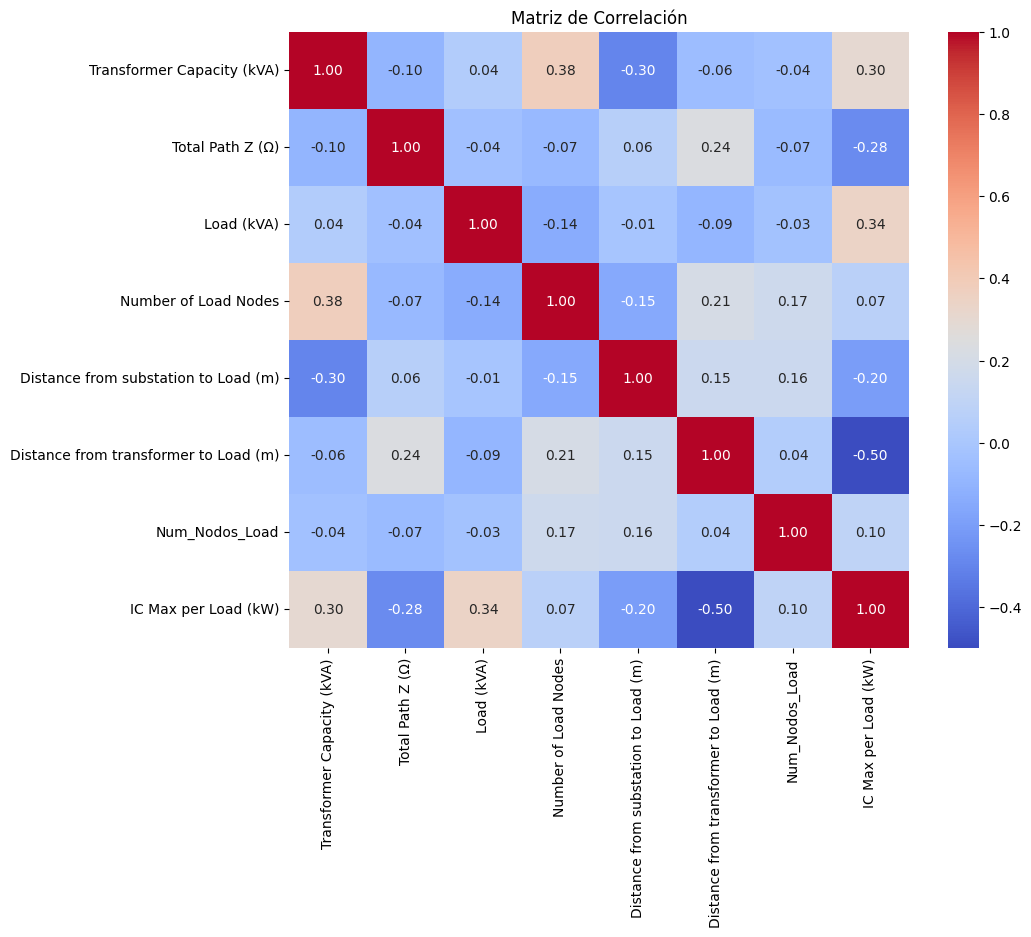

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

# Con los valores obtenidos y para un mejor análisis se crea una matriz de correlación
# Crear una matriz de correlación
correlacion = df_final[[
    'Transformer Capacity (kVA)',
    'Total Path Z (Ω)',
    'Load (kVA)',
    'Number of Load Nodes',
    'Distance from substation to Load (m)',
    'Distance from transformer to Load (m)',
    'Num_Nodos_Load',
    'IC Max per Load (kW)'
]].corr()

# Visualizar la matriz de correlación
plt.figure(figsize=(10, 8))
sns.heatmap(correlacion, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Matriz de Correlación')
plt.show()

En general las correlaciones son bajas por lo que todos los features son relevantes para la creación del modelo de aprendizaje.

In [15]:
# Se definen las entradas y salidas para entrenar y probar los modelos
X = df_final.loc[:, features].copy()
y = df_final.loc[:, target].copy()

## Prueba de implementación de algoritmo de regresión lineal

### Linear Support Vector Regression

In [16]:
from sklearn.svm import LinearSVR
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, root_mean_squared_error, r2_score, mean_absolute_error

# Separación de subconjuntos para entrenamiento y pruebas.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [17]:
# Parámetros iniciales

params_svr = {
    # epsilon=0.0,
    # tol=0.0001,
    # C=1.0,
    # loss='epsilon_insensitive',
    # fit_intercept=True,
    # intercept_scaling=1.0,
    # dual='auto',
    # verbose=0,
    # random_state=None,
    # max_iter=1000,
}

In [18]:
# Crear el modelo
linear_reg = LinearSVR(**params_svr)

# Entrenar el modelo
linear_reg.fit(X_train, y_train)

c:\Users\luisd\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVR()

In [19]:
# Realizar predicciones
y_pred_linear = linear_reg.predict(X_test)

In [20]:
# Calcular las métricas
mse = mean_squared_error(y_test, y_pred_linear)
rmse = root_mean_squared_error(y_test, y_pred_linear)
r2 = r2_score(y_test, y_pred_linear)

# Obtener el Training Score (R² en el conjunto de entrenamiento)
train_score = linear_reg.score(X_train, y_train)

# Obtener el Testing Score (R² en el conjunto de prueba)
test_score = linear_reg.score(X_test, y_test)

# Calculo del MAE
mae_linear = mean_absolute_error(y_test, y_pred_linear)

print(f'Mean Squared Error: {mse}')
print(f'Root Mean Squared Error: {rmse}')
print(f'R^2 Score: {r2}')
print(f"Training Score (R²): {train_score}")
print(f"Testing Score (R²): {test_score}")
print(f"MAE: {mae_linear}")

Mean Squared Error: 703.3183514505492
Root Mean Squared Error: 26.52014991380232
R^2 Score: -14.15011889634739
Training Score (R²): -14.26589595244041
Testing Score (R²): -14.15011889634739
MAE: 22.36739947362445


Dada la forma de los datos utilizados, al utilizar un kernel lineal para la regresión, el algoritmo es incapaz de converger correctamente y dar valores de error y puntuaciones safistactorias. De hecho se puede notar en la celda anterior que estas métricas son bastante malas, aún haciendo pruebas con otros hiper-parámetros en el algortimo.

Por esta razón, a continuación se exploran diferentes algoritmos no lineales que logren mejores resultados.

## Implementación de KNN

### Prueba inicial para KNN

In [21]:
# Para el uso de KNN es necesario normalizar las características:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [22]:
# Librerías
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, root_mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import cross_val_score
import numpy as np
import matplotlib.pyplot as plt
import timeit

In [23]:
# División del dataset en entrenamiento y prueba para KNN. Es diferente de los demás algoritmos, ya que en este se usa el X escalado
X_train_knn, X_test_knn, y_train_knn, y_test_knn = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Verificar los tamaños de los conjuntos
print(f"Conjunto de entrenamiento: {X_train_knn.shape}")
print(f"Conjunto de prueba: {X_test_knn.shape}")

Conjunto de entrenamiento: (63099, 7)
Conjunto de prueba: (15775, 7)


In [24]:
# Crear el modelo KNN
knn = KNeighborsRegressor(n_neighbors=5)  # Este es el hiperparámetro que se ajusta en KNN idealmente inicia en 5

# Entrenar el modelo
knn.fit(X_train_knn, y_train_knn)

# Realizar predicciones
knn_y_pred = knn.predict(X_test_knn)

In [25]:
# Análisis de las métricas
mse_knn = mean_squared_error(y_test_knn, knn_y_pred)
rmse_knn = root_mean_squared_error(y_test_knn, knn_y_pred)
r2_knn = r2_score(y_test_knn, knn_y_pred)

print(f'Mean Squared Error: {mse_knn}')
print(f'Root Mean Squared Error: {rmse_knn}')
print(f'R^2 Score: {r2_knn}')

# Obtener el Training Score (R² en el conjunto de entrenamiento)
train_score_knn = knn.score(X_train_knn, y_train_knn)

# Obtener el Testing Score (R² en el conjunto de prueba)
test_score_knn = knn.score(X_test_knn, y_test_knn)

# Calculo del MAE
mae_knn = mean_absolute_error(y_test_knn, knn_y_pred)

print(f"Training Score (R²): {train_score_knn}")
print(f"Testing Score (R²): {test_score_knn}")

print(f"MAE: {mae_knn}")

Mean Squared Error: 8.660096499716033
Root Mean Squared Error: 2.942804189835952
R^2 Score: 0.8134536211746145
Training Score (R²): 0.8806124478581538
Testing Score (R²): 0.8134536211746145
MAE: 1.4717572289231113


### Optimización de los hiperparámetros
Se determina que deben haber mejores hiperparámetros, por lo que se intenta revisar cual es el mejor numero de vecinos (n_neighbors). Para esto se hace un análisis desde 1 hasta 21:

Mejor valor de n_neighbors: 3


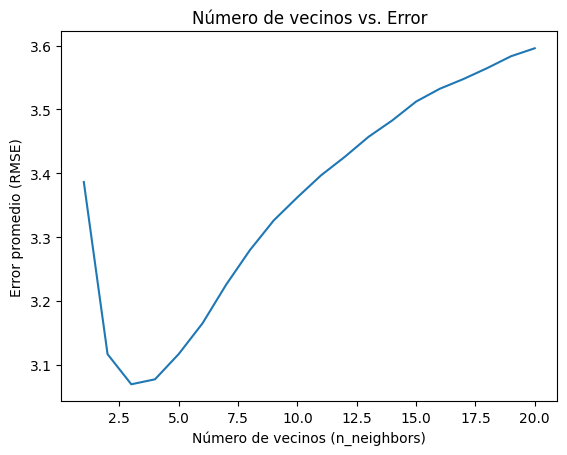

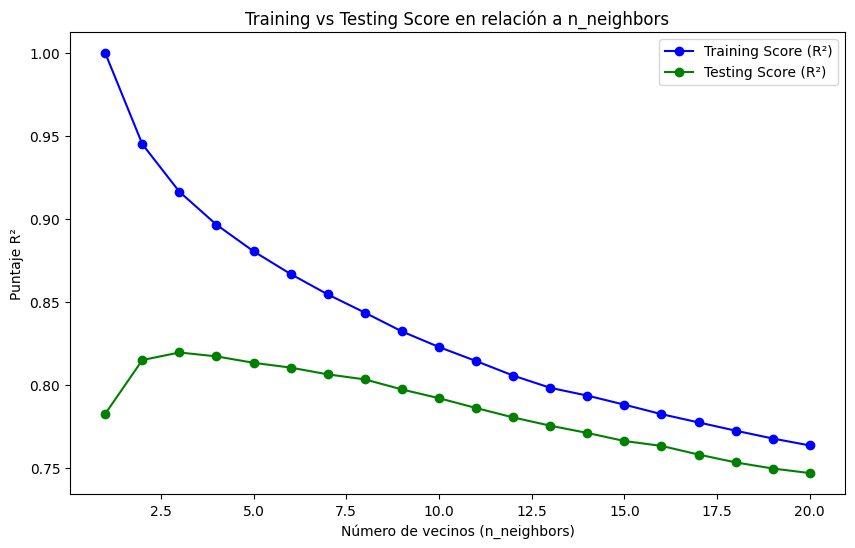

In [26]:
scores = []
train_scores = []
test_scores = []

# Probar diferentes valores de n_neighbors
for k in range(1, 21):
    knn = KNeighborsRegressor(n_neighbors=k)
    # Realizar cross-validation con 5 particiones (cv=5)
    cv_scores = cross_val_score(knn, X_train_knn, y_train_knn, cv=5, scoring='neg_root_mean_squared_error')

    knn.fit(X_train_knn, y_train_knn)
    # Obtener el Training Score (R² en el conjunto de entrenamiento)
    train_scores.append(knn.score(X_train_knn, y_train_knn))

    # Obtener el Testing Score (R² en el conjunto de prueba)
    test_scores.append(knn.score(X_test_knn, y_test_knn))

    # Calcular el puntaje promedio (usar negativo porque cross_val_score devuelve errores negativos)
    scores.append(-1*np.mean(cv_scores))

# Encontrar el valor de n_neighbors con el menor error
best_k = np.argmin(scores) + 1
print(f"Mejor valor de n_neighbors: {best_k}")

# Graficar los puntajes
plt.plot(range(1, 21), scores)
plt.xlabel('Número de vecinos (n_neighbors)')
plt.ylabel('Error promedio (RMSE)')
plt.title('Número de vecinos vs. Error')
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(range(1, 21), train_scores, label='Training Score (R²)', color='blue', marker='o')
plt.plot(range(1, 21), test_scores, label='Testing Score (R²)', color='green', marker='o')

# Añadir etiquetas y título
plt.xlabel('Número de vecinos (n_neighbors)')
plt.ylabel('Puntaje R²')
plt.title('Training vs Testing Score en relación a n_neighbors')

# Añadir la leyenda
plt.legend()

# Mostrar el gráfico
plt.show()

Ahora se harán pruebas variando otros hiperámetros del algoritmo, en especial la función de pesos usada en la predicción.
El valor defaul es "uniform". Ahora se probará con "distance".

In [27]:
knn = KNeighborsRegressor(n_neighbors=3, weights='distance')  # Se ajusta el hiperparámetro "weights" para ver las diferencias.

knn.fit(X_train_knn, y_train_knn)

knn_y_pred = knn.predict(X_test_knn)

mse = mean_squared_error(y_test_knn, knn_y_pred)
rmse = root_mean_squared_error(y_test_knn, knn_y_pred)
r2 = r2_score(y_test_knn, knn_y_pred)

# Obtener el Training Score (R² en el conjunto de entrenamiento)
train_score = knn.score(X_train_knn, y_train_knn)
# Obtener el Testing Score (R² en el conjunto de prueba)
test_score = knn.score(X_test_knn, y_test_knn)
# Calculo del MAE
mae_knn = mean_absolute_error(y_test_knn, knn_y_pred)

print(f'Mean Squared Error: {mse}')
print(f'Root Mean Squared Error: {rmse}')
print(f'R^2 Score: {r2}')
print(f"Training Score (R²): {train_score}")
print(f"Testing Score (R²): {test_score}")
print(f"MAE: {mae_knn}")

Mean Squared Error: 7.863515867043481
Root Mean Squared Error: 2.80419611779267
R^2 Score: 0.8306126946875219
Training Score (R²): 1.0
Testing Score (R²): 0.8306126946875219
MAE: 1.2756907452271944


Como los resultados muestran un claro overfitting para la puntuación de entranamiento, se desecha la idea de utilizar la función "distance" para el cálculo de pesos y se retorna al valor default.

### Medición de Métricas

El resultado del análisis indica que el mejor numero de vecinos es 3, por lo que se ejecuta el algoritmo con este valor y se vuelven a imprimir las metricas


In [28]:
import tracemalloc
tracemalloc.start()

knn = KNeighborsRegressor(n_neighbors=3)  # Este es el hiperparámetro que se ajusta en KNN idealmente inicia en 5

# Ajusto los modelos a funciones, esto con el fin de poder obtener un tiempo de ejecución tanto para el entrenamiento como para la predicción
# Entrenar el modelo
def train_model():
    knn.fit(X_train_knn, y_train_knn)

# Realizar predicciones
def predict_model():
    global knn_y_pred_t
    knn_y_pred_t = knn.predict(X_test_knn)

train_time_knn = timeit.timeit(train_model, number=1)
print(f"Tiempo de entrenamiento: {train_time_knn:.2f} segundos")

predict_time_knn = timeit.timeit(predict_model, number=1)
print(f"Tiempo de predicción: {predict_time_knn:.2f} segundos")

memoria_knn, peak_knn = tracemalloc.get_traced_memory()
print(f"Uso de memoria actual: {memoria_knn / 10**6:.2f} MB")
print(f"Pico de uso de memoria: {peak_knn / 10**6:.2f} MB")
tracemalloc.stop()

mse_knn_final = mean_squared_error(y_test_knn, knn_y_pred_t)
rmse_knn_final = root_mean_squared_error(y_test_knn, knn_y_pred_t)
r2_knn_final = r2_score(y_test_knn, knn_y_pred_t)

# Obtener el Training Score (R² en el conjunto de entrenamiento)
train_score_knn_final = knn.score(X_train_knn, y_train_knn)
# Obtener el Testing Score (R² en el conjunto de prueba)
test_score_knn_final = knn.score(X_test_knn, y_test_knn)
# Calculo del MAE
mae_knn_final = mean_absolute_error(y_test_knn, knn_y_pred_t)

print(f'Mean Squared Error: {mse_knn_final}')
print(f'Root Mean Squared Error: {rmse_knn_final}')
print(f'R^2 Score: {r2_knn_final}')
print(f"Training Score (R²): {train_score_knn_final}")
print(f"Testing Score (R²): {test_score_knn_final}")
print(f"MAE: {mae_knn_final}")

Tiempo de entrenamiento: 0.14 segundos
Tiempo de predicción: 0.69 segundos
Uso de memoria actual: 1.24 MB
Pico de uso de memoria: 2.25 MB
Mean Squared Error: 8.371039606899624
Root Mean Squared Error: 2.893274893075254
R^2 Score: 0.8196801703396484
Training Score (R²): 0.9164726568566212
Testing Score (R²): 0.8196801703396484
MAE: 1.3640569715462674


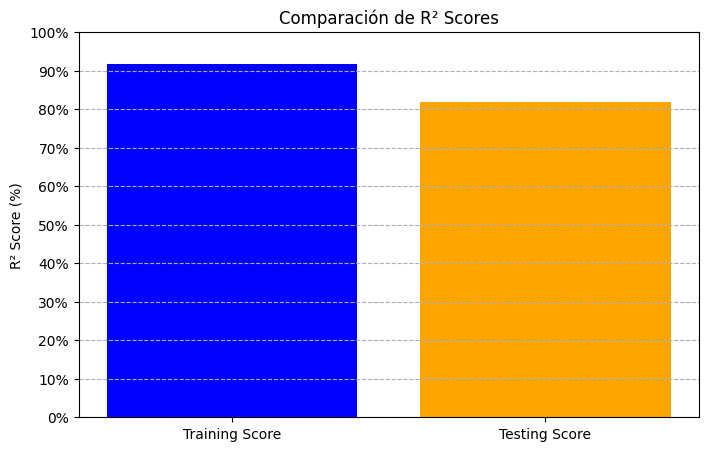

In [29]:
# Con los datos obtenidos se imprimen los resultados:
# Valores de R²
scores = [train_score_knn_final, test_score_knn_final]
labels = ['Training Score', 'Testing Score']

# Convertir a porcentaje
scores_percentage = [score * 100 for score in scores]

# Crear gráfico de barras
plt.figure(figsize=(8, 5))
plt.bar(labels, scores_percentage, color=['blue', 'orange'])
plt.ylim(0, 100)  # Rango de porcentaje
plt.ylabel('R² Score (%)')
plt.title('Comparación de R² Scores')
plt.grid(axis='y', linestyle='--')

# Formatear etiquetas en el eje y como porcentaje
plt.yticks(ticks=np.arange(0, 101, 10), labels=[f'{int(tick)}%' for tick in np.arange(0, 101, 10)])

plt.show()

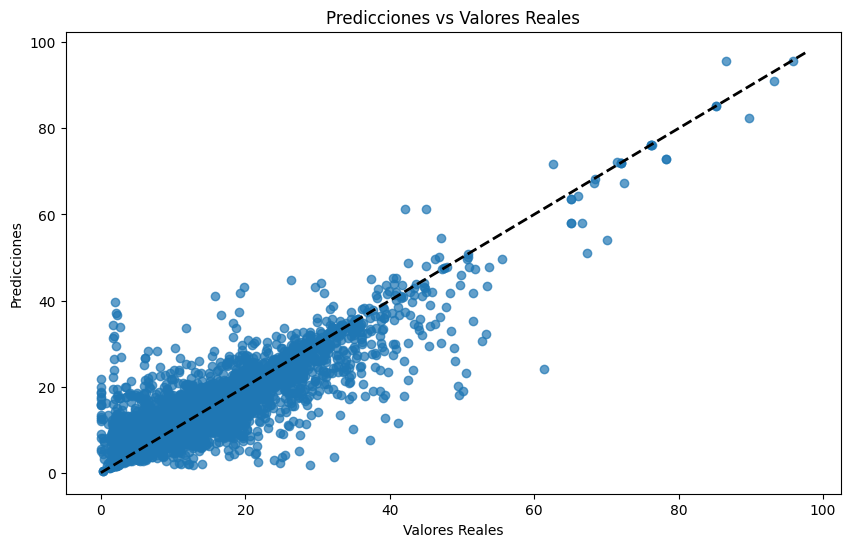

In [30]:
# se realiza un análisis de la predicción de los valores:
plt.figure(figsize=(10, 6))
plt.scatter(y_test_knn, knn_y_pred_t, alpha=0.7)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
plt.xlabel('Valores Reales')
plt.ylabel('Predicciones')
plt.title('Predicciones vs Valores Reales')
plt.show()

In [31]:
# Entrenamiento para los demás modelos.
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

## Implementación de Random Forest

### Prueba inicial para Random Forest

In [32]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

In [33]:
# Crear el modelo

rf = RandomForestRegressor(n_estimators=100, random_state=42)

# Entrenar el modelo
rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)


In [34]:
# Se calculan las metricas del Random Forest.

mse_rf = mean_squared_error(y_test, y_pred_rf)
rmse_rf = root_mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

# Obtener el Training Score (R² en el conjunto de entrenamiento)
train_score_rf = rf.score(X_train, y_train)

# Obtener el Testing Score (R² en el conjunto de prueba)
test_score_rf = rf.score(X_test, y_test)

# Calculo del MAE
mae_rf = mean_absolute_error(y_test, y_pred_rf)

# Imprimir los resultados
print(f'Mean Squared Error: {mse_rf}')
print(f'Root Mean Squared Error: {rmse_rf}')
print(f'R^2 Score: {r2_rf}')
print(f"Training Score (R²): {train_score_rf}")
print(f"Testing Score (R²): {test_score_rf}")
print(f"MAE: {mae_rf}")

Mean Squared Error: 5.749554407971958
Root Mean Squared Error: 2.3978228474956107
R^2 Score: 0.8761493529890954
Training Score (R²): 0.9811736633575577
Testing Score (R²): 0.8761493529890954
MAE: 1.283374780005728


### Optimización de los Hiperparámetros

Se probarán diferentes valores de max_depth para encontrar el óptimo.

Mejor valor de max_depth: 19


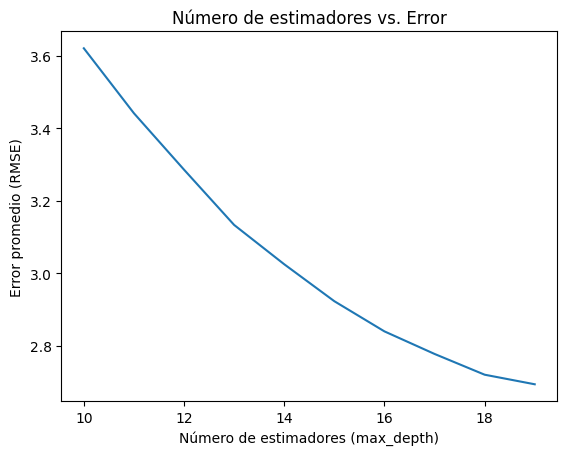

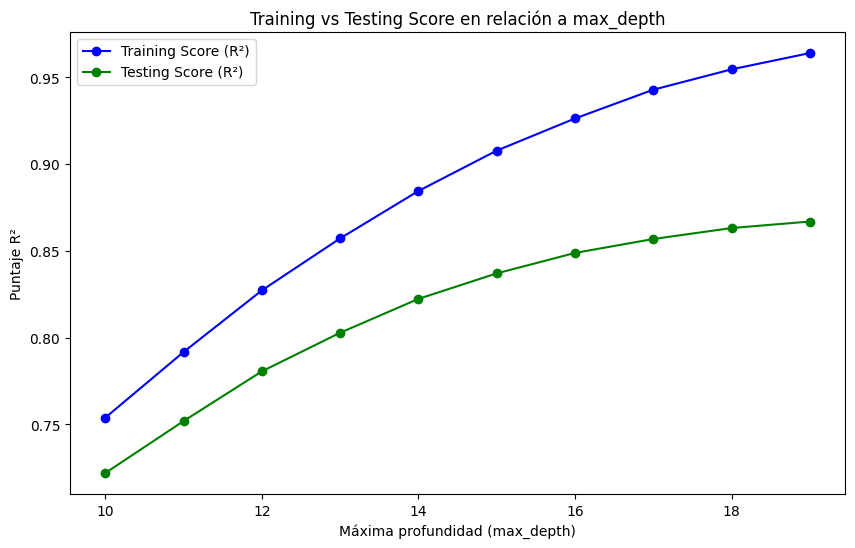

In [35]:
from sklearn.model_selection import cross_val_score
import numpy as np

scores = []
train_scores = []
test_scores = []

range_test = range(10, 20)

# Probar diferentes valores de n_estimators
for n in range_test:
    rf = RandomForestRegressor(n_estimators=106, max_depth=n)

    # Realizar cross-validation con 5 particiones (cv=5)
    cv_scores = cross_val_score(rf, X_train, y_train, cv=5, scoring='neg_root_mean_squared_error')

    rf.fit(X_train, y_train)
    # Obtener el Training Score (R² en el conjunto de entrenamiento)
    train_scores.append(rf.score(X_train, y_train))

    # Obtener el Testing Score (R² en el conjunto de prueba)
    test_scores.append(rf.score(X_test, y_test))

    # Calcular el puntaje promedio (usar negativo porque cross_val_score devuelve errores negativos)
    scores.append(-1*np.mean(cv_scores))

# Encontrar el valor de max_depth con el menor error
best_n = 10 + np.argmin(scores)
print(f"Mejor valor de max_depth: {best_n}")

# Graficar los puntajes
plt.plot(range_test, scores)
plt.xlabel('Número de estimadores (max_depth)')
plt.ylabel('Error promedio (RMSE)')
plt.title('Número de estimadores vs. Error')
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(range_test, train_scores, label='Training Score (R²)', color='blue', marker='o')
plt.plot(range_test, test_scores, label='Testing Score (R²)', color='green', marker='o')

# Añadir etiquetas y título
plt.xlabel('Máxima profundidad (max_depth)')
plt.ylabel('Puntaje R²')
plt.title('Training vs Testing Score en relación a max_depth')

# Añadir la leyenda
plt.legend()

# Mostrar el gráfico
plt.show()

Se probarán diferentes valores de n_estimators para encontrar el óptimo.

Mejor valor de n_estimators: 108


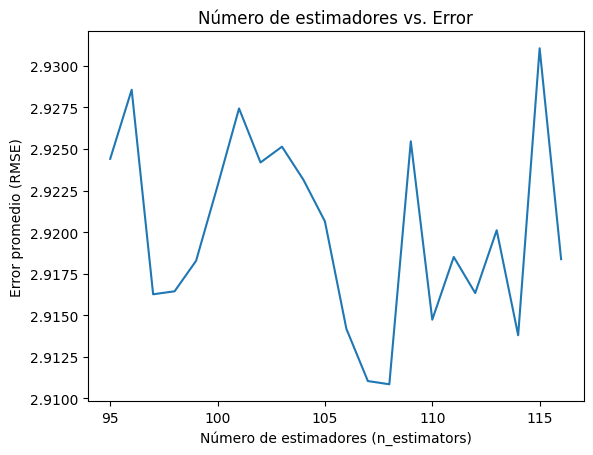

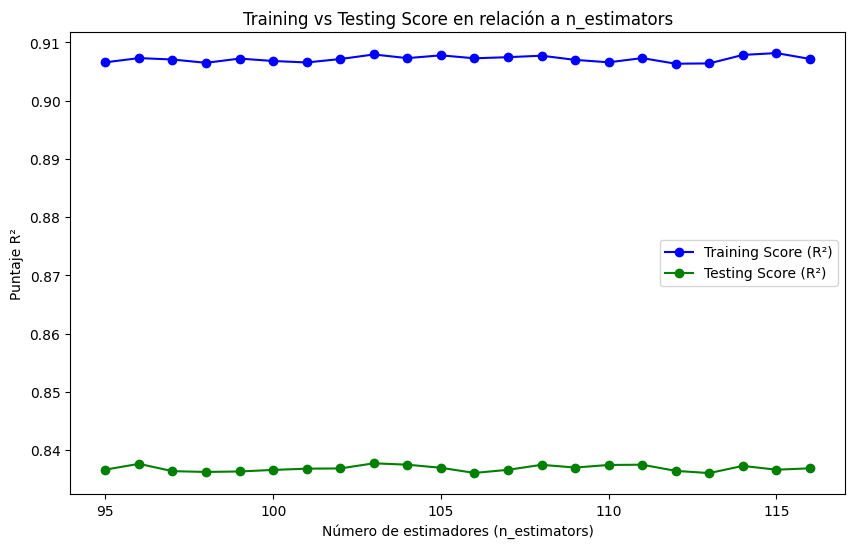

In [36]:
from sklearn.model_selection import cross_val_score
import numpy as np

scores = []
train_scores = []
test_scores = []

range_test = range(95, 117, 1)

# Probar diferentes valores de n_estimators
for n in range_test:
    rf = RandomForestRegressor(n_estimators=n, max_depth=15)

    # Realizar cross-validation con 5 particiones (cv=5)
    cv_scores = cross_val_score(rf, X_train, y_train, cv=5, scoring='neg_root_mean_squared_error')

    rf.fit(X_train, y_train)
    # Obtener el Training Score (R² en el conjunto de entrenamiento)
    train_scores.append(rf.score(X_train, y_train))

    # Obtener el Testing Score (R² en el conjunto de prueba)
    test_scores.append(rf.score(X_test, y_test))

    # Calcular el puntaje promedio (usar negativo porque cross_val_score devuelve errores negativos)
    scores.append(-1*np.mean(cv_scores))

# Encontrar el valor de n_estimators con el menor error
best_n = 95 + np.argmin(scores)
print(f"Mejor valor de n_estimators: {best_n}")

# Graficar los puntajes
plt.plot(range_test, scores)
plt.xlabel('Número de estimadores (n_estimators)')
plt.ylabel('Error promedio (RMSE)')
plt.title('Número de estimadores vs. Error')
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(range_test, train_scores, label='Training Score (R²)', color='blue', marker='o')
plt.plot(range_test, test_scores, label='Testing Score (R²)', color='green', marker='o')

# Añadir etiquetas y título
plt.xlabel('Número de estimadores (n_estimators)')
plt.ylabel('Puntaje R²')
plt.title('Training vs Testing Score en relación a n_estimators')

# Añadir la leyenda
plt.legend()

# Mostrar el gráfico
plt.show()

In [37]:
# Crear el modelo

rf = RandomForestRegressor(n_estimators=106, max_depth=15, random_state=42)

# Entrenar el modelo
rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)


In [38]:
# Se calculan las metricas del Random Forest.

mse_rf = mean_squared_error(y_test, y_pred_rf)
rmse_rf = root_mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

# Obtener el Training Score (R² en el conjunto de entrenamiento)
train_score_rf = rf.score(X_train, y_train)

# Obtener el Testing Score (R² en el conjunto de prueba)
test_score_rf = rf.score(X_test, y_test)

# Calculo del MAE
mae_rf = mean_absolute_error(y_test, y_pred_rf)

# Imprimir los resultados
print(f'Mean Squared Error: {mse_rf}')
print(f'Root Mean Squared Error: {rmse_rf}')
print(f'R^2 Score: {r2_rf}')
print(f"Training Score (R²): {train_score_rf}")
print(f"Testing Score (R²): {test_score_rf}")
print(f"MAE: {mae_rf}")

Mean Squared Error: 7.557568144084719
Root Mean Squared Error: 2.7491031526817467
R^2 Score: 0.8372030877425762
Training Score (R²): 0.9076049859844353
Testing Score (R²): 0.8372030877425762
MAE: 1.574223725189698


Para mejorar los resultados se realiza una busqueda de Grid Search para encontrar los mejores parámetros.


In [39]:
# Mejores parámetros encontrados: {'n_estimators': 184, 'max_depth': 48, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2'}

# Definir los parámetros a probar
param_grid = {
    'n_estimators': [10, 50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt']
}

rf = RandomForestRegressor(random_state=42) # n_estimators=10 da un muy buen resultado ;Mean Squared Error (Random Forest): 40.11068269701386 y R² Score (Random Forest): 0.902790660423813
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=5,
    n_jobs=-1,
    verbose=10,
)

# Entrenar el modelo
grid_search.fit(X_train, y_train)

# Realizar predicciones en el conjunto de prueba
print("Mejores parámetros encontrados:", grid_search.best_params_)

Fitting 5 folds for each of 288 candidates, totalling 1440 fits


c:\Users\luisd\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
720 fits failed out of a total of 1440.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
547 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\luisd\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\luisd\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py", line 1466, in wrapper
    estimator._validate_params()
  File "c:\Users\luisd\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\bas

Mejores parámetros encontrados: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}


El resultado del Grid Search indica:
Mejores parámetros encontrados: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Por lo que se ejecuta el algoritmo con dichos parámetros

Como siguiete paso después del grid search se implementa una busqueda de parámetros con una optimización Bayesiana, esto con el objetivo de comparar los resultados obtenidos con el grid search y encontrar aún mejores hiper parámetros

In [40]:
import optuna
from sklearn.model_selection import cross_val_score


def objective(trial):
    # Definir el espacio de búsqueda
    n_estimators = trial.suggest_int('n_estimators', 50, 500)
    max_depth = trial.suggest_categorical('max_depth', [None] + list(range(1, 51)))
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
    max_features = trial.suggest_categorical('max_features', [None, 'sqrt', 'log2'])

    rf = RandomForestRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        random_state=42
    )

    # Validación cruzada
    scores = cross_val_score(rf, X_train, y_train, cv=5, scoring='neg_root_mean_squared_error')
    return -scores.mean()

# Ejecutar la optimización
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

c:\Users\luisd\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2024-11-25 19:15:06,221] A new study created in memory with name: no-name-ca6cfc4b-a405-43bb-960f-a8c9d88c4523
[I 2024-11-25 19:17:16,612] Trial 0 finished with value: 3.1185225148670446 and parameters: {'n_estimators': 276, 'max_depth': 38, 'min_samples_split': 10, 'min_samples_leaf': 7, 'max_features': 'sqrt'}. Best is trial 0 with value: 3.1185225148670446.
[I 2024-11-25 19:18:07,491] Trial 1 finished with value: 5.64813590056296 and parameters: {'n_estimators': 258, 'max_depth': 2, 'min_samples_split': 7, 'min_samples_leaf': 9, 'max_features': None}. Best is trial 0 with value: 3.1185225148670446.
[I 2024-11-25 19:23:20,103] Trial 2 finished with value: 3.0547890814213012 and parameters: {'n_estimators': 2

In [41]:
# Mostrar los mejores parámetros
print("Mejores parámetros encontrados:", study.best_params)

Mejores parámetros encontrados: {'n_estimators': 378, 'max_depth': None, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt'}


La búsqueda Bayeciana da como resultado los siguientes parámetros a utilizar :
Mejores parámetros encontrados: {'n_estimators': 184, 'max_depth': 48, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2'}.
Luego se procede a ejecutar tanto con los parámetros encontrados por la búsqueda bayeciana, como por gridsearch.

In [42]:
best_rf = RandomForestRegressor(
    max_depth=None,
    max_features='sqrt',
    min_samples_leaf=1,
    min_samples_split=2,
    n_estimators=200,
    random_state=42
)

def train_model():
    best_rf.fit(X_train, y_train)

def predict_model():
    global y_pred_grid_rf
    y_pred_grid_rf = best_rf.predict(X_test)

train_time_grid_rf = timeit.timeit(train_model, number=1)
print(f"Tiempo de entrenamiento: {train_time_grid_rf:.2f} segundos")

predict_time_grid_rf = timeit.timeit(predict_model, number=1)
print(f"Tiempo de predicción: {predict_time_grid_rf:.2f} segundos")

# Evaluar el modelo
mse_grid_rf = mean_squared_error(y_test, y_pred_grid_rf)
rmse_grid_rf = root_mean_squared_error(y_test, y_pred_grid_rf)
r2_grid_rf = r2_score(y_test, y_pred_grid_rf)

train_score_grid_rf = best_rf.score(X_train, y_train)

test_score_grid_rf = best_rf.score(X_test, y_test)

mae_grid_rf = mean_absolute_error(y_test, y_pred_grid_rf)
print(f'Mean Squared Error (Mejor Random Forest): {mse_grid_rf}')
print(f'Root Mean Squared Error (Mejor Random Forest): {rmse_grid_rf}')
print(f'R² Score (Mejor Random Forest): {r2_grid_rf}')
print(f"Training Score (R²): {train_score_grid_rf}")
print(f"Testing Score (R²): {test_score_grid_rf}")
print(f"MAE: {mae_grid_rf}")

Tiempo de entrenamiento: 28.05 segundos
Tiempo de predicción: 0.94 segundos
Mean Squared Error (Mejor Random Forest): 5.95865748121562
Root Mean Squared Error (Mejor Random Forest): 2.4410361491005452
R² Score (Mejor Random Forest): 0.8716450820359779
Training Score (R²): 0.981951084216809
Testing Score (R²): 0.8716450820359779
MAE: 1.3488703394791421


In [43]:
# Mejores parámetros encontrados: con busqueda bayeciana {'n_estimators': 184, 'max_depth': 48, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2'}

bayeciana_rf = RandomForestRegressor(
    max_depth=48,
    max_features='log2',
    min_samples_leaf=1,
    min_samples_split=2,
    n_estimators=185,
    random_state=42
)

def train_model():
    bayeciana_rf.fit(X_train, y_train)

def predict_model():
    global y_pred_bayeciana_rf
    y_pred_bayeciana_rf = bayeciana_rf.predict(X_test)

train_time_bayeciana_rf = timeit.timeit(train_model, number=1)
print(f"Tiempo de entrenamiento: {train_time_bayeciana_rf:.2f} segundos")

predict_time_bayeciana_rf = timeit.timeit(predict_model, number=1)
print(f"Tiempo de predicción: {predict_time_bayeciana_rf:.2f} segundos")

# Evaluar el modelo
mse_bayeciana_rf = mean_squared_error(y_test, y_pred_bayeciana_rf)
rmse_bayeciana_rf = root_mean_squared_error(y_test, y_pred_bayeciana_rf)
r2_bayeciana_rf = r2_score(y_test, y_pred_bayeciana_rf)

train_score_bayeciana_rf = bayeciana_rf.score(X_train, y_train)

test_score_bayeciana_rf = bayeciana_rf.score(X_test, y_test)

mae_bayeciana_rf = mean_absolute_error(y_test, y_pred_bayeciana_rf)
print(f'Mean Squared Error (Mejor Random Forest): {mse_bayeciana_rf}')
print(f'Root Mean Squared Error (Mejor Random Forest): {rmse_bayeciana_rf}')
print(f'R² Score (Mejor Random Forest): {r2_bayeciana_rf}')
print(f"Training Score (R²): {train_score_bayeciana_rf}")
print(f"Testing Score (R²): {test_score_bayeciana_rf}")
print(f"MAE: {mae_bayeciana_rf}")


Tiempo de entrenamiento: 25.89 segundos
Tiempo de predicción: 0.87 segundos
Mean Squared Error (Mejor Random Forest): 5.95804402115964
Root Mean Squared Error (Mejor Random Forest): 2.440910490198205
R² Score (Mejor Random Forest): 0.8716582965252161
Training Score (R²): 0.981925068435337
Testing Score (R²): 0.8716582965252161
MAE: 1.348832000941697


Con los valores del gridsearV se tiene como resultados:
Mean Squared Error (Mejor Random Forest): 5.95865748121562
Root Mean Squared Error (Mejor Random Forest): 2.4410361491005452
R² Score (Mejor Random Forest): 0.8716450820359779
Training Score (R²): 0.981951084216809
Testing Score (R²): 0.8716450820359779
MAE: 1.3488703394791421


Con la optimización Bayesiana:

Mean Squared Error (Mejor Random Forest): 5.95804402115964
Root Mean Squared Error (Mejor Random Forest): 2.440910490198205
R² Score (Mejor Random Forest): 0.8716582965252161
Training Score (R²): 0.981925068435337
Testing Score (R²): 0.8716582965252161
MAE: 1.348832000941697


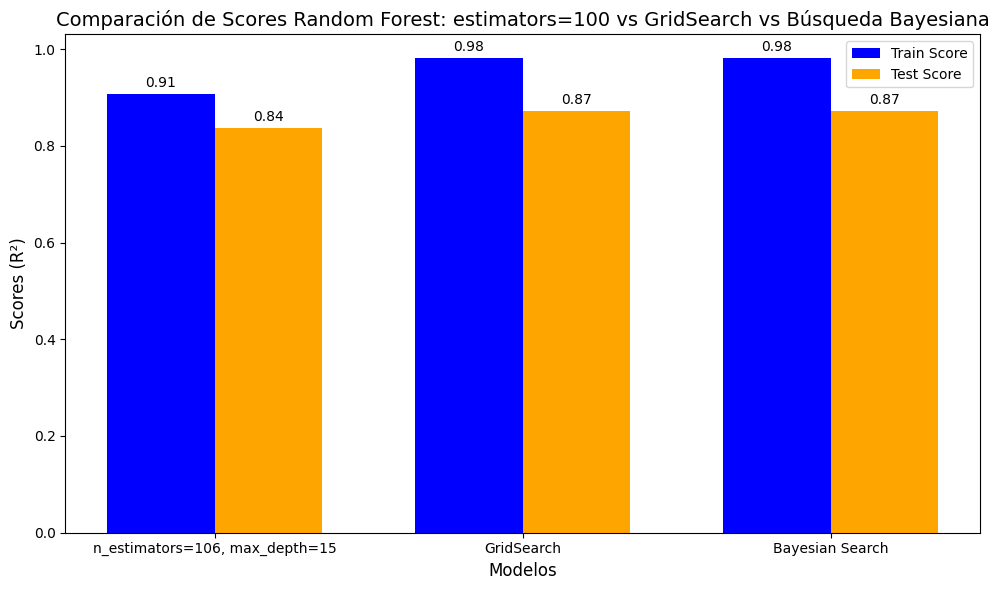

In [44]:
# Datos de puntajes
scores = {
    "n_estimators=106, max_depth=15": [train_score_rf, test_score_rf],
    "GridSearch": [train_score_grid_rf, test_score_grid_rf],
    "Bayesian Search": [train_score_bayeciana_rf, test_score_bayeciana_rf],
}

# Convertir los datos en formato para graficar
labels = list(scores.keys())  # Modelos
train_scores = [score[0] for score in scores.values()]  # Train scores
test_scores = [score[1] for score in scores.values()]  # Test scores

# Configuración del gráfico
x = np.arange(len(labels))  # Posiciones en el eje X
width = 0.35  # Ancho de las barras

fig, ax = plt.subplots(figsize=(10, 6))

# Barras de train_score
bars1 = ax.bar(x - width/2, train_scores, width, label='Train Score', color='blue')

# Barras de test_score
bars2 = ax.bar(x + width/2, test_scores, width, label='Test Score', color='orange')

# Etiquetas y título
ax.set_xlabel('Modelos', fontsize=12)
ax.set_ylabel('Scores (R²)', fontsize=12)
ax.set_title('Comparación de Scores Random Forest: estimators=100 vs GridSearch vs Búsqueda Bayesiana', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# Agregar valores encima de las barras
for bar in bars1 + bars2:
    height = bar.get_height()
    ax.annotate(f'{height:.2f}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),  # Desplazamiento del texto
                textcoords="offset points",
                ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

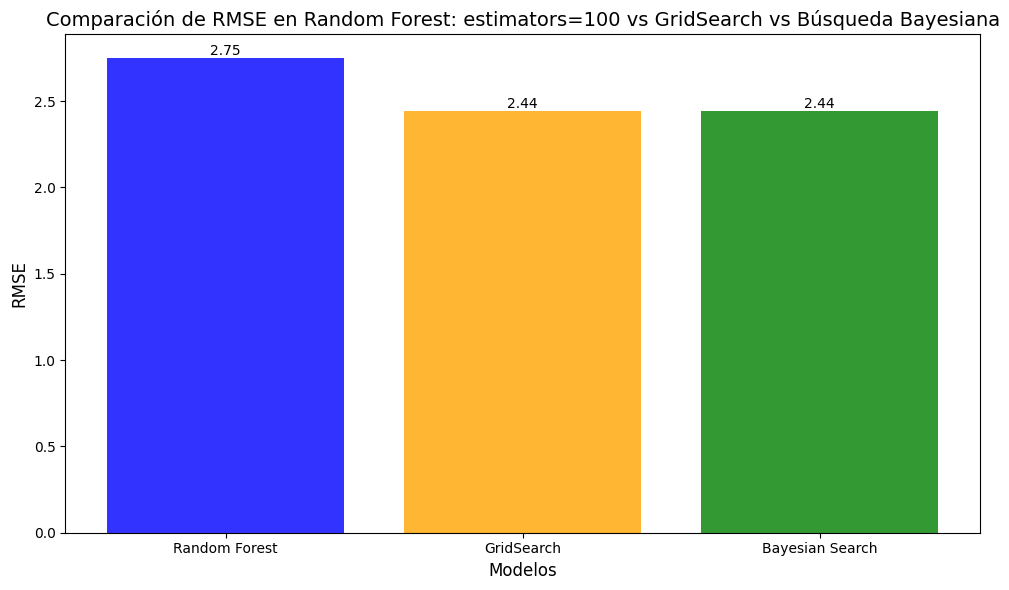

In [45]:
# Datos de RMSE
models = ['Random Forest', 'GridSearch', 'Bayesian Search']
rmse_values = [rmse_rf, rmse_grid_rf, rmse_bayeciana_rf]

# Crear el gráfico
plt.figure(figsize=(10, 6))
bars = plt.bar(models, rmse_values, color=['blue', 'orange', 'green'], alpha=0.8)

# Agregar etiquetas y título
plt.xlabel('Modelos', fontsize=12)
plt.ylabel('RMSE', fontsize=12)
plt.title('Comparación de RMSE en Random Forest: estimators=100 vs GridSearch vs Búsqueda Bayesiana', fontsize=14)

# Mostrar valores encima de las barras
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.2f}', 
             ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

### Medición de Métricas

Este análisis permite determinar, que apesar de que se hizo una búsqueda exaustiva de los mejores hiperparámetros, los parámetros n_estimators=106 y max_depth=15 es la que ofrece mejores resultados.

In [46]:
# Crear el modelo
best_rf = RandomForestRegressor(
    n_estimators=106,
    max_depth=15,
    random_state=42)

tracemalloc.start()
# Entrenar el modelo
def train_model_rf():
    best_rf.fit(X_train, y_train)

# Realizar predicciones
def predict_model_rf():
    global y_pred_best_rf
    y_pred_best_rf = best_rf.predict(X_test)


train_time_rf = timeit.timeit(train_model_rf, number=1)
print(f"Tiempo de entrenamiento: {train_time_rf:.2f} segundos")


predict_time_rf = timeit.timeit(predict_model_rf, number=1)
print(f"Tiempo de predicción: {predict_time_rf:.2f} segundos")

memoria_rf, peak_rf = tracemalloc.get_traced_memory()
print(f"Uso de memoria actual: {memoria_rf / 10**6:.2f} MB")
print(f"Pico de uso de memoria: {peak_rf / 10**6:.2f} MB")
tracemalloc.stop()

Tiempo de entrenamiento: 30.04 segundos
Tiempo de predicción: 0.27 segundos
Uso de memoria actual: 0.25 MB
Pico de uso de memoria: 5.31 MB


In [47]:
# Evaluar el modelo
mse_best_rf = mean_squared_error(y_test, y_pred_best_rf)
rmse_best_rf = root_mean_squared_error(y_test, y_pred_best_rf)
r2_best_rf = r2_score(y_test, y_pred_best_rf)

train_score_best_rf = best_rf.score(X_train, y_train)

test_score_best_rf = best_rf.score(X_test, y_test)

mae_best_rf = mean_absolute_error(y_test, y_pred_best_rf)

print(f'Mean Squared Error (Mejor Gradient Boosting): {mse_best_rf}')
print(f'Root Mean Squared Error (Mejor Gradient Boosting): {rmse_best_rf}')
print(f'R² Score (Mejor Gradient Boosting): {r2_best_rf}')
print(f"Training Score (R²): {train_score_best_rf}")
print(f"Testing Score (R²): {test_score_best_rf}")
print(f"MAE: {mae_best_rf}")

Mean Squared Error (Mejor Gradient Boosting): 7.557568144084719
Root Mean Squared Error (Mejor Gradient Boosting): 2.7491031526817467
R² Score (Mejor Gradient Boosting): 0.8372030877425762
Training Score (R²): 0.9076049859844353
Testing Score (R²): 0.8372030877425762
MAE: 1.574223725189698


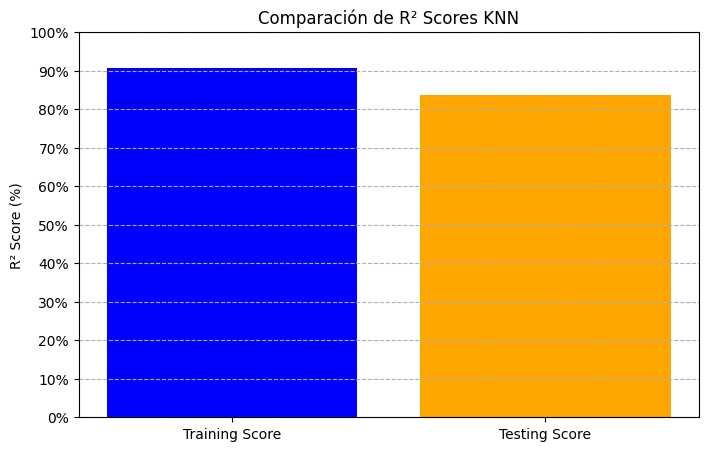

In [48]:
# Se grafican los resultados obtenidos:
# Valores de R²
scores = [train_score_best_rf, test_score_best_rf]
labels = ['Training Score', 'Testing Score']

# Convertir a porcentaje
scores_percentage = [score * 100 for score in scores]

# Crear gráfico de barras
plt.figure(figsize=(8, 5))
plt.bar(labels, scores_percentage, color=['blue', 'orange'])
plt.ylim(0, 100)  # Rango de porcentaje
plt.ylabel('R² Score (%)')
plt.title('Comparación de R² Scores KNN')
plt.grid(axis='y', linestyle='--')

# Formatear etiquetas en el eje y como porcentaje
plt.yticks(ticks=np.arange(0, 101, 10), labels=[f'{int(tick)}%' for tick in np.arange(0, 101, 10)])

plt.show()

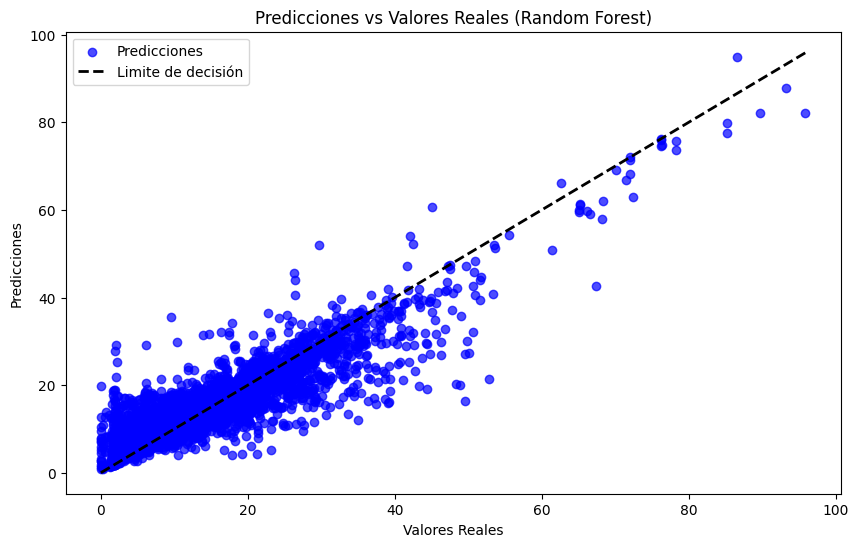

In [49]:
# Crear la gráfica
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_best_rf, alpha=0.7, color='b', label='Predicciones')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2, label='Limite de decisión')

# Etiquetas y título
plt.xlabel('Valores Reales')
plt.ylabel('Predicciones')
plt.title('Predicciones vs Valores Reales (Random Forest)')
plt.legend()
plt.show()

## Implementación de GradientBoostingRegressor

### Prueba inicial para GradientBoostingRegressor

In [50]:
from sklearn.ensemble import GradientBoostingRegressor

In [51]:
# Parámetros iniciales

params = {
    # "loss": "squared_error",
    # "learning_rate": 0.1,
    # "n_estimators": 100,
    # "subsample": 1.0,
    # "criterion": "friedman_mse",
    # "min_samples_split": 2,
    # "min_samples_leaf": 1,
    # "min_weight_fraction_leaf": 0.0,
    # "max_depth": 3,
    # "min_impurity_decrease": 0.0,
    # "init": None,
    "random_state": 42,
    # "max_features": None,
    # "alpha": 0.9,
    # "verbose": 0,
    # "max_leaf_nodes": None,
    # "warm_start": False,
    # "validation_fraction": 0.1,
    # "n_iter_no_change": None,
    # "tol": 0.0001,
    # "ccp_alpha": 0.0,
}

In [52]:
# Crear el modelo
reg = GradientBoostingRegressor(**params)

# Entrenar el modelo
reg.fit(X_train, y_train)

# Realizar predicciones
y_pred_gbr = reg.predict(X_test)

In [53]:
# Calcular las métricas
mse = mean_squared_error(y_test, y_pred_gbr)
rmse = root_mean_squared_error(y_test, y_pred_gbr)
r2 = r2_score(y_test, y_pred_gbr)

# Obtener el Training Score (R² en el conjunto de entrenamiento)
train_score = reg.score(X_train, y_train)

# Obtener el Testing Score (R² en el conjunto de prueba)
test_score = reg.score(X_test, y_test)

# Calculo del MAE
mae_gbr = mean_absolute_error(y_test, y_pred_gbr)

print(f'Mean Squared Error: {mse}')
print(f'Root Mean Squared Error: {rmse}')
print(f'R^2 Score: {r2}')
print(f"Training Score (R²): {train_score}")
print(f"Testing Score (R²): {test_score}")
print(f"MAE: {mae_gbr}")

Mean Squared Error: 16.363314457832903
Root Mean Squared Error: 4.0451593859615596
R^2 Score: 0.6475192790530802
Training Score (R²): 0.6648771438215115
Testing Score (R²): 0.6475192790530802
MAE: 2.583384619856514


### Optimización de los hiperparámetros

Mejor valor de n_estimators: 998


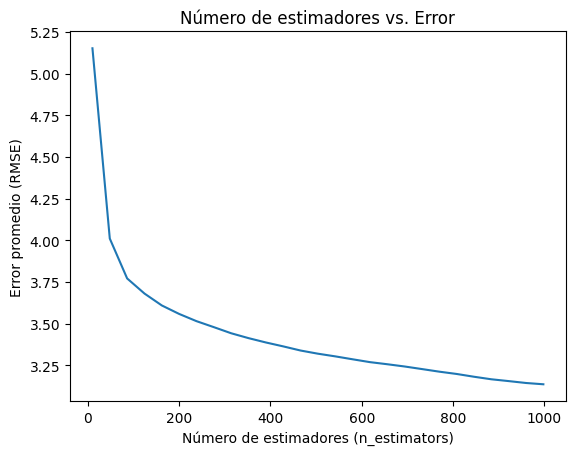

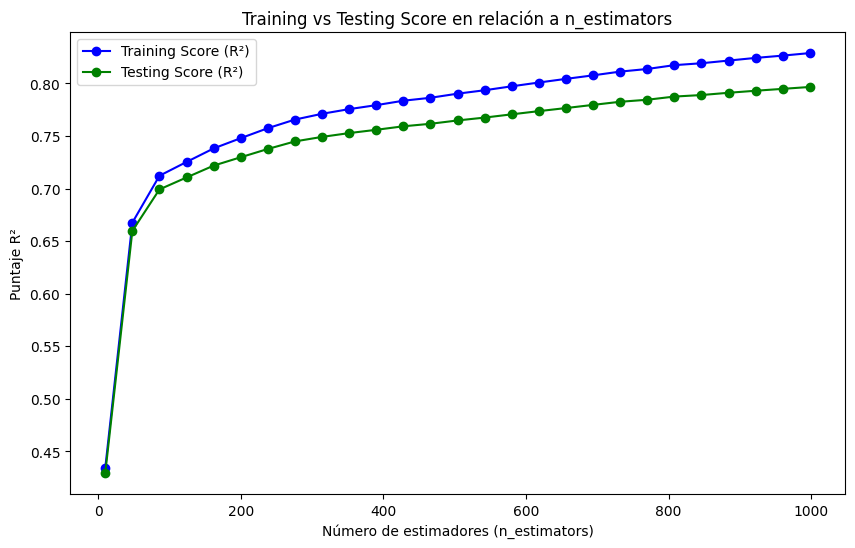

In [54]:
scores = []
train_scores = []
test_scores = []

range_test = range(10, 1036, 38)

# Probar diferentes valores de n_estimators
for n in range_test:
    gbr = GradientBoostingRegressor(
        learning_rate=0.1,
        n_estimators=n,
        min_samples_split=600,
        min_samples_leaf=60,
        max_depth=5,
        random_state=42,
        max_features='sqrt',
    )
    # Realizar cross-validation con 5 particiones (cv=5)
    cv_scores = cross_val_score(gbr, X_train, y_train, cv=5, scoring='neg_root_mean_squared_error')

    gbr.fit(X_train, y_train)
    # Obtener el Training Score (R² en el conjunto de entrenamiento)
    train_scores.append(gbr.score(X_train, y_train))

    # Obtener el Testing Score (R² en el conjunto de prueba)
    test_scores.append(gbr.score(X_test, y_test))

    # Calcular el puntaje promedio (usar negativo porque cross_val_score devuelve errores negativos)
    scores.append(-1*np.mean(cv_scores))

# Encontrar el valor de n_estimators con el menor error
best_n = 10 + np.argmin(scores)*38
print(f"Mejor valor de n_estimators: {best_n}")

# Graficar los puntajes
plt.plot(range_test, scores)
plt.xlabel('Número de estimadores (n_estimators)')
plt.ylabel('Error promedio (RMSE)')
plt.title('Número de estimadores vs. Error')
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(range_test, train_scores, label='Training Score (R²)', color='blue', marker='o')
plt.plot(range_test, test_scores, label='Testing Score (R²)', color='green', marker='o')

# Añadir etiquetas y título
plt.xlabel('Número de estimadores (n_estimators)')
plt.ylabel('Puntaje R²')
plt.title('Training vs Testing Score en relación a n_estimators')

# Añadir la leyenda
plt.legend()

# Mostrar el gráfico
plt.show()

Mejor valor de min_samples_split: 2


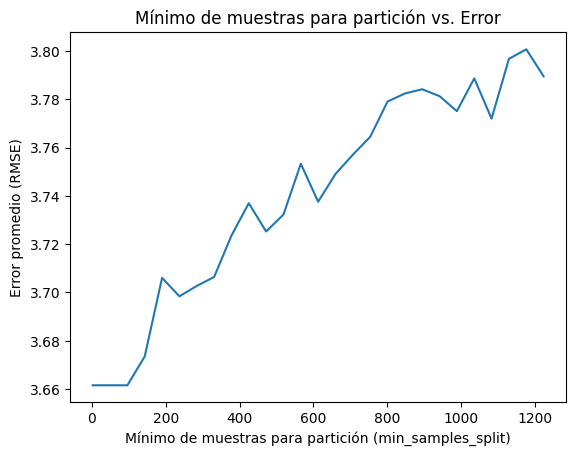

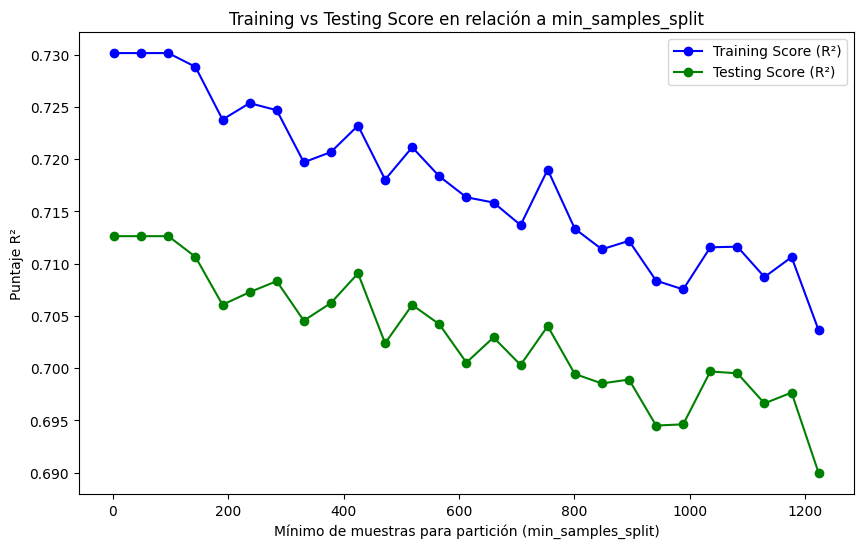

In [55]:
scores = []
train_scores = []
test_scores = []

range_test = range(2, 1271, 47)

# Probar diferentes valores de min_samples_split
for n in range_test:
    gbr = GradientBoostingRegressor(
        learning_rate=0.1,
        n_estimators=100,
        min_samples_split=n,
        min_samples_leaf=60,
        max_depth=5,
        random_state=42,
        max_features='sqrt',
    )
    # Realizar cross-validation con 5 particiones (cv=5)
    cv_scores = cross_val_score(gbr, X_train, y_train, cv=5, scoring='neg_root_mean_squared_error')

    gbr.fit(X_train, y_train)
    # Obtener el Training Score (R² en el conjunto de entrenamiento)
    train_scores.append(gbr.score(X_train, y_train))

    # Obtener el Testing Score (R² en el conjunto de prueba)
    test_scores.append(gbr.score(X_test, y_test))

    # Calcular el puntaje promedio (usar negativo porque cross_val_score devuelve errores negativos)
    scores.append(-1*np.mean(cv_scores))

# Encontrar el valor de min_samples_split con el menor error
best_n = 2 + np.argmin(scores)*47
print(f"Mejor valor de min_samples_split: {best_n}")

# Graficar los puntajes
plt.plot(range_test, scores)
plt.xlabel('Mínimo de muestras para partición (min_samples_split)')
plt.ylabel('Error promedio (RMSE)')
plt.title('Mínimo de muestras para partición vs. Error')
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(range_test, train_scores, label='Training Score (R²)', color='blue', marker='o')
plt.plot(range_test, test_scores, label='Testing Score (R²)', color='green', marker='o')

# Añadir etiquetas y título
plt.xlabel('Mínimo de muestras para partición (min_samples_split)')
plt.ylabel('Puntaje R²')
plt.title('Training vs Testing Score en relación a min_samples_split')

# Añadir la leyenda
plt.legend()

# Mostrar el gráfico
plt.show()

Mejor valor de min_samples_leaf: 6


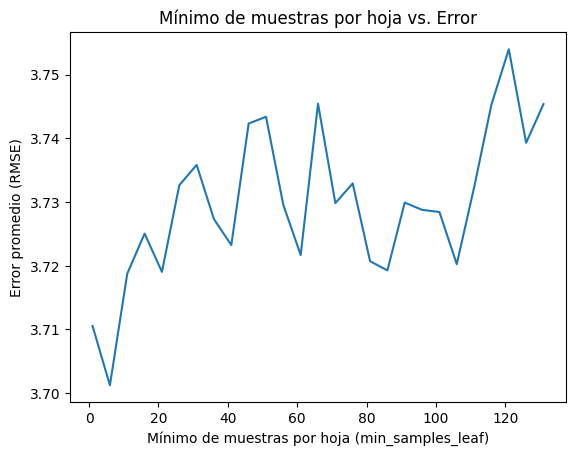

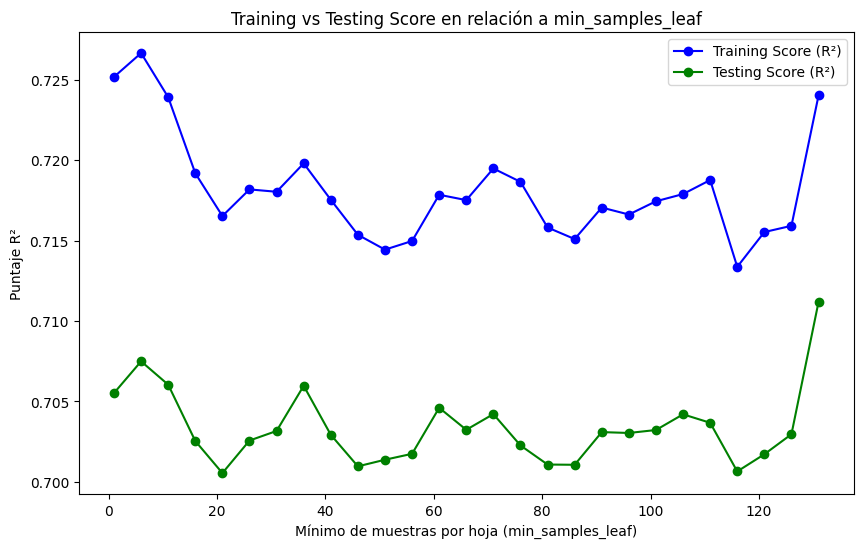

In [56]:
scores = []
train_scores = []
test_scores = []

range_test = range(1, 136, 5)

# Probar diferentes valores de min_samples_leaf
for n in range_test:
    gbr = GradientBoostingRegressor(
        learning_rate=0.1,
        n_estimators=100,
        min_samples_split=600,
        min_samples_leaf=n,
        max_depth=5,
        random_state=42,
        max_features='sqrt',
    )
    # Realizar cross-validation con 5 particiones (cv=5)
    cv_scores = cross_val_score(gbr, X_train, y_train, cv=5, scoring='neg_root_mean_squared_error')

    gbr.fit(X_train, y_train)
    # Obtener el Training Score (R² en el conjunto de entrenamiento)
    train_scores.append(gbr.score(X_train, y_train))

    # Obtener el Testing Score (R² en el conjunto de prueba)
    test_scores.append(gbr.score(X_test, y_test))

    # Calcular el puntaje promedio (usar negativo porque cross_val_score devuelve errores negativos)
    scores.append(-1*np.mean(cv_scores))

# Encontrar el valor de min_samples_leaf con el menor error
best_n = 1 + np.argmin(scores)*5
print(f"Mejor valor de min_samples_leaf: {best_n}")

# Graficar los puntajes
plt.plot(range_test, scores)
plt.xlabel('Mínimo de muestras por hoja (min_samples_leaf)')
plt.ylabel('Error promedio (RMSE)')
plt.title('Mínimo de muestras por hoja vs. Error')
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(range_test, train_scores, label='Training Score (R²)', color='blue', marker='o')
plt.plot(range_test, test_scores, label='Testing Score (R²)', color='green', marker='o')

# Añadir etiquetas y título
plt.xlabel('Mínimo de muestras por hoja (min_samples_leaf)')
plt.ylabel('Puntaje R²')
plt.title('Training vs Testing Score en relación a min_samples_leaf')

# Añadir la leyenda
plt.legend()

# Mostrar el gráfico
plt.show()

Mejor valor de max_depth: 27


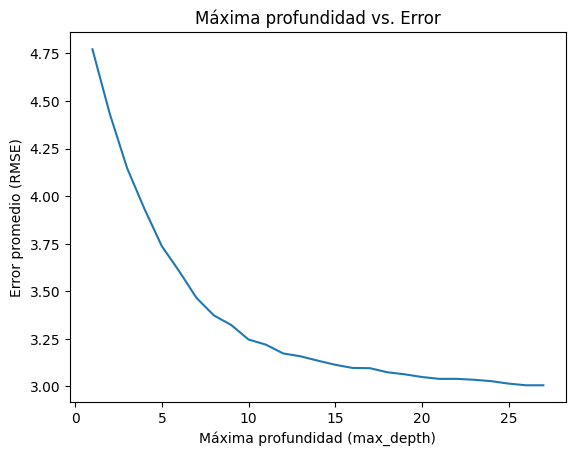

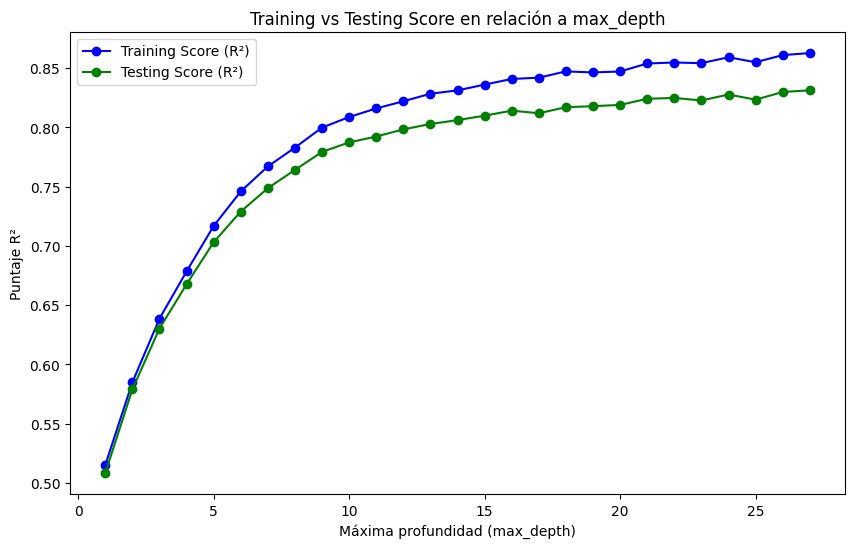

In [57]:
scores = []
train_scores = []
test_scores = []

range_test = range(1, 28)

# Probar diferentes valores de max_depth
for n in range_test:
    gbr = GradientBoostingRegressor(
        learning_rate=0.1,
        n_estimators=100,
        min_samples_split=600,
        min_samples_leaf=60,
        max_depth=n,
        random_state=42,
        max_features='sqrt',
    )
    # Realizar cross-validation con 5 particiones (cv=5)
    cv_scores = cross_val_score(gbr, X_train, y_train, cv=5, scoring='neg_root_mean_squared_error')

    gbr.fit(X_train, y_train)
    # Obtener el Training Score (R² en el conjunto de entrenamiento)
    train_scores.append(gbr.score(X_train, y_train))

    # Obtener el Testing Score (R² en el conjunto de prueba)
    test_scores.append(gbr.score(X_test, y_test))

    # Calcular el puntaje promedio (usar negativo porque cross_val_score devuelve errores negativos)
    scores.append(-1*np.mean(cv_scores))

# Encontrar el valor de max_depth con el menor error
best_n = np.argmin(scores) + 1
print(f"Mejor valor de max_depth: {best_n}")

# Graficar los puntajes
plt.plot(range_test, scores)
plt.xlabel('Máxima profundidad (max_depth)')
plt.ylabel('Error promedio (RMSE)')
plt.title('Máxima profundidad vs. Error')
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(range_test, train_scores, label='Training Score (R²)', color='blue', marker='o')
plt.plot(range_test, test_scores, label='Testing Score (R²)', color='green', marker='o')

# Añadir etiquetas y título
plt.xlabel('Máxima profundidad (max_depth)')
plt.ylabel('Puntaje R²')
plt.title('Training vs Testing Score en relación a max_depth')

# Añadir la leyenda
plt.legend()

# Mostrar el gráfico
plt.show()

In [58]:
best_grb = GradientBoostingRegressor(
    learning_rate=0.1,
    n_estimators=100,
    min_samples_split=2,
    min_samples_leaf=6,
    max_depth=27,
    random_state=42,
    max_features='sqrt',
)

best_grb.fit(X_train, y_train)

y_pred_best_grb = best_grb.predict(X_test)

# Evaluar el modelo
mse_best_grb = mean_squared_error(y_test, y_pred_best_grb)
rmse_best_grb = root_mean_squared_error(y_test, y_pred_best_grb)
r2_best_grb = r2_score(y_test, y_pred_best_grb)

train_score_best_gbr = best_grb.score(X_train, y_train)

test_score_best_gbr = best_grb.score(X_test, y_test)

mae_best_grb = mean_absolute_error(y_test, y_pred_best_grb)
print(f'Mean Squared Error (Mejor Gradient Boosting): {mse_best_grb}')
print(f'Root Mean Squared Error (Mejor Gradient Boosting): {rmse_best_grb}')
print(f'R² Score (Mejor Gradient Boosting): {r2_best_grb}')
print(f"Training Score (R²): {train_score_best_gbr}")
print(f"Testing Score (R²): {test_score_best_gbr}")
print(f"MAE: {mae_best_grb}")

Mean Squared Error (Mejor Gradient Boosting): 4.527623305259856
Root Mean Squared Error (Mejor Gradient Boosting): 2.127821257826854
R² Score (Mejor Gradient Boosting): 0.9024708636550015
Training Score (R²): 0.9966088195231736
Testing Score (R²): 0.9024708636550015
MAE: 1.1533018721839663


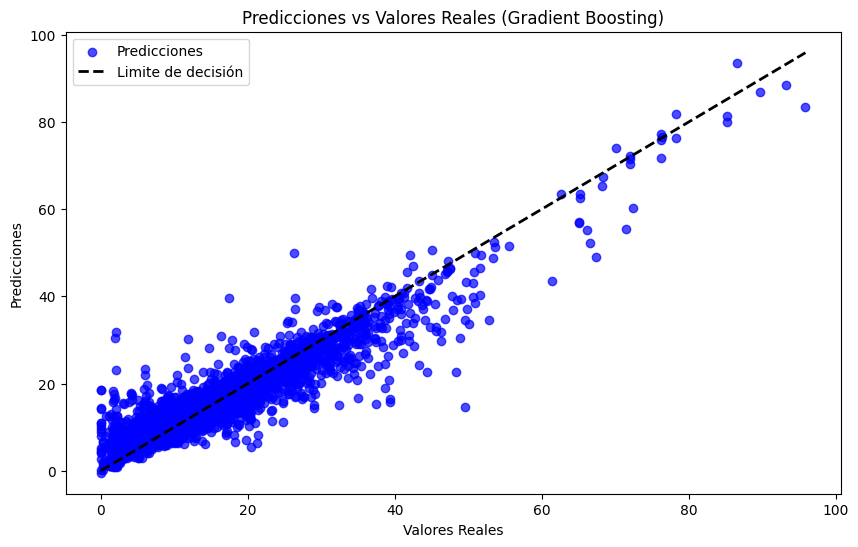

In [59]:
# Crear la gráfica
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_best_grb, alpha=0.7, color='b', label='Predicciones')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2, label='Limite de decisión')

# Etiquetas y título
plt.xlabel('Valores Reales')
plt.ylabel('Predicciones')
plt.title('Predicciones vs Valores Reales (Gradient Boosting)')
plt.legend()
plt.show()

Mejor valor de min_samples_split: 25


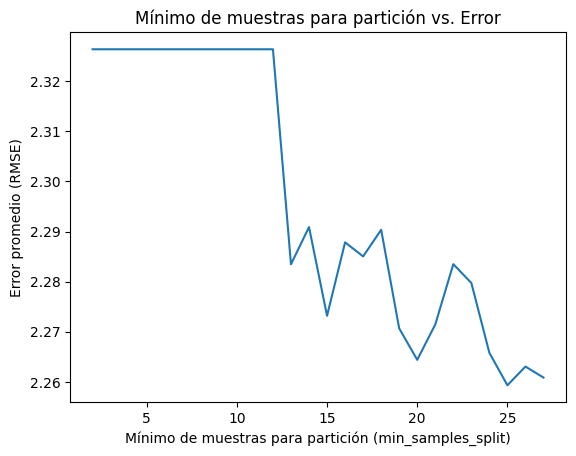

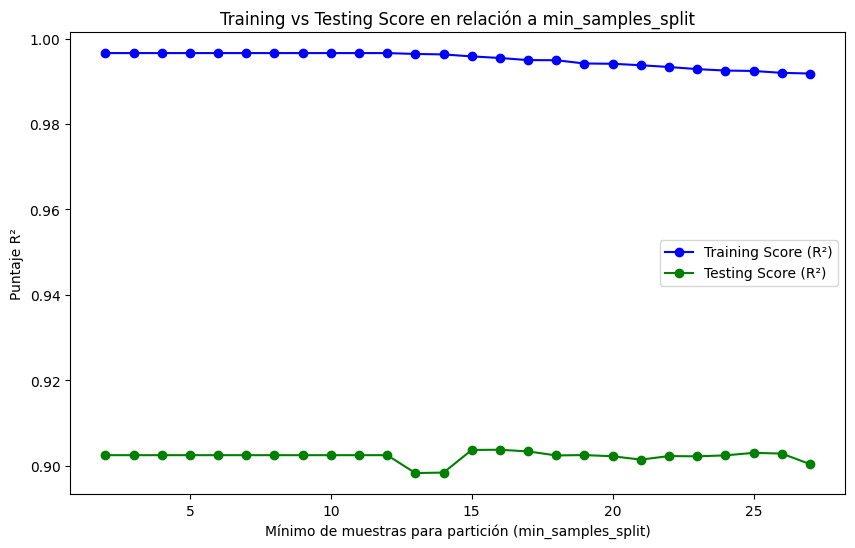

In [60]:
scores = []
train_scores = []
test_scores = []

range_test = range(2, 28)

# Probar diferentes valores de min_samples_split
for n in range_test:
    gbr = GradientBoostingRegressor(
        learning_rate=0.1,
        n_estimators=100,
        min_samples_split=n,
        min_samples_leaf=6,
        max_depth=27,
        random_state=42,
        max_features='sqrt',
    )
    # Realizar cross-validation con 5 particiones (cv=5)
    cv_scores = cross_val_score(gbr, X_train, y_train, cv=5, scoring='neg_root_mean_squared_error')

    gbr.fit(X_train, y_train)
    # Obtener el Training Score (R² en el conjunto de entrenamiento)
    train_scores.append(gbr.score(X_train, y_train))

    # Obtener el Testing Score (R² en el conjunto de prueba)
    test_scores.append(gbr.score(X_test, y_test))

    # Calcular el puntaje promedio (usar negativo porque cross_val_score devuelve errores negativos)
    scores.append(-1*np.mean(cv_scores))

# Encontrar el valor de min_samples_split con el menor error
best_n = 2 + np.argmin(scores)
print(f"Mejor valor de min_samples_split: {best_n}")

# Graficar los puntajes
plt.plot(range_test, scores)
plt.xlabel('Mínimo de muestras para partición (min_samples_split)')
plt.ylabel('Error promedio (RMSE)')
plt.title('Mínimo de muestras para partición vs. Error')
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(range_test, train_scores, label='Training Score (R²)', color='blue', marker='o')
plt.plot(range_test, test_scores, label='Testing Score (R²)', color='green', marker='o')

# Añadir etiquetas y título
plt.xlabel('Mínimo de muestras para partición (min_samples_split)')
plt.ylabel('Puntaje R²')
plt.title('Training vs Testing Score en relación a min_samples_split')

# Añadir la leyenda
plt.legend()

# Mostrar el gráfico
plt.show()

Mejor valor de min_samples_leaf: 8


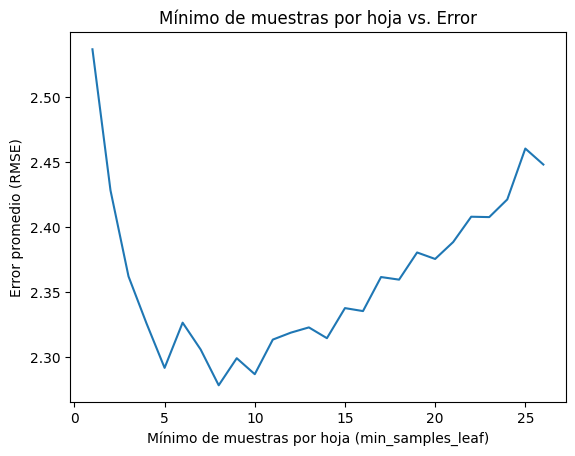

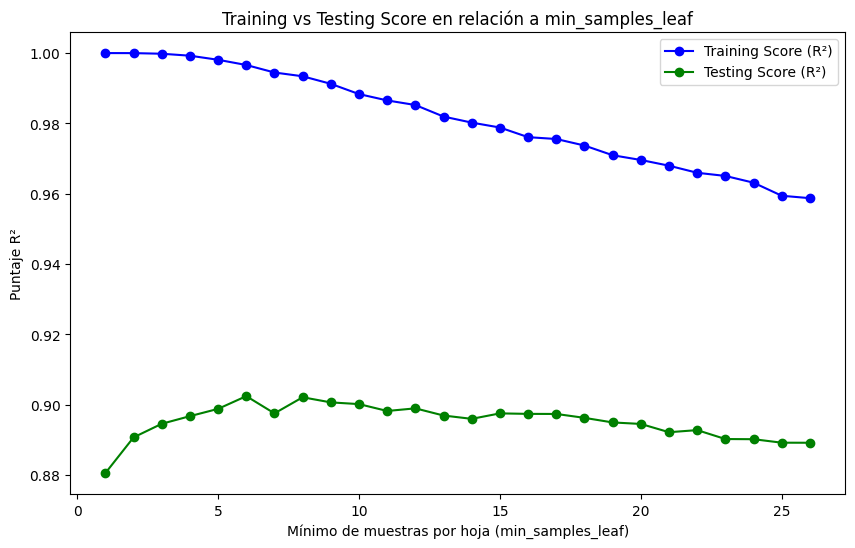

In [61]:
scores = []
train_scores = []
test_scores = []

range_test = range(1, 27)

# Probar diferentes valores de min_samples_leaf
for n in range_test:
    gbr = GradientBoostingRegressor(
        learning_rate=0.1,
        n_estimators=100,
        min_samples_split=2,
        min_samples_leaf=n,
        max_depth=27,
        random_state=42,
        max_features='sqrt',
    )
    # Realizar cross-validation con 5 particiones (cv=5)
    cv_scores = cross_val_score(gbr, X_train, y_train, cv=5, scoring='neg_root_mean_squared_error')

    gbr.fit(X_train, y_train)
    # Obtener el Training Score (R² en el conjunto de entrenamiento)
    train_scores.append(gbr.score(X_train, y_train))

    # Obtener el Testing Score (R² en el conjunto de prueba)
    test_scores.append(gbr.score(X_test, y_test))

    # Calcular el puntaje promedio (usar negativo porque cross_val_score devuelve errores negativos)
    scores.append(-1*np.mean(cv_scores))

# Encontrar el valor de min_samples_leaf con el menor error
best_n = 1 + np.argmin(scores)
print(f"Mejor valor de min_samples_leaf: {best_n}")

# Graficar los puntajes
plt.plot(range_test, scores)
plt.xlabel('Mínimo de muestras por hoja (min_samples_leaf)')
plt.ylabel('Error promedio (RMSE)')
plt.title('Mínimo de muestras por hoja vs. Error')
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(range_test, train_scores, label='Training Score (R²)', color='blue', marker='o')
plt.plot(range_test, test_scores, label='Testing Score (R²)', color='green', marker='o')

# Añadir etiquetas y título
plt.xlabel('Mínimo de muestras por hoja (min_samples_leaf)')
plt.ylabel('Puntaje R²')
plt.title('Training vs Testing Score en relación a min_samples_leaf')

# Añadir la leyenda
plt.legend()

# Mostrar el gráfico
plt.show()

Mejor valor de max_depth: 23


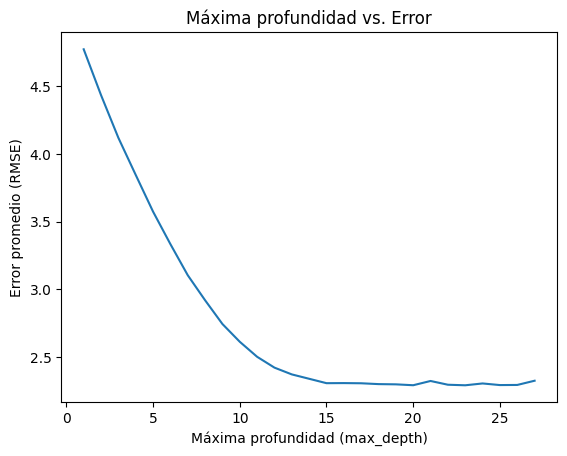

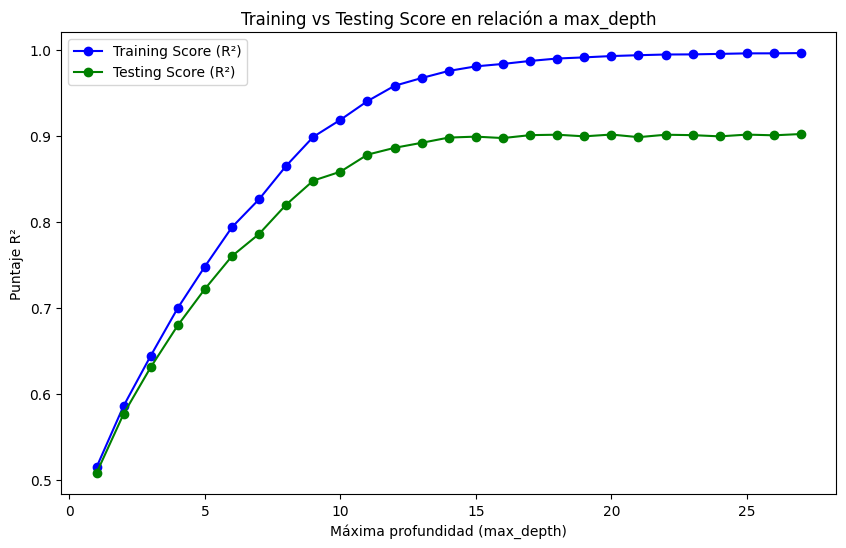

In [62]:
scores = []
train_scores = []
test_scores = []

range_test = range(1, 28)

# Probar diferentes valores de max_depth
for n in range_test:
    gbr = GradientBoostingRegressor(
        learning_rate=0.1,
        n_estimators=100,
        min_samples_split=2,
        min_samples_leaf=6,
        max_depth=n,
        random_state=42,
        max_features='sqrt',
    )
    # Realizar cross-validation con 5 particiones (cv=5)
    cv_scores = cross_val_score(gbr, X_train, y_train, cv=5, scoring='neg_root_mean_squared_error')

    gbr.fit(X_train, y_train)
    # Obtener el Training Score (R² en el conjunto de entrenamiento)
    train_scores.append(gbr.score(X_train, y_train))

    # Obtener el Testing Score (R² en el conjunto de prueba)
    test_scores.append(gbr.score(X_test, y_test))

    # Calcular el puntaje promedio (usar negativo porque cross_val_score devuelve errores negativos)
    scores.append(-1*np.mean(cv_scores))

# Encontrar el valor de max_depth con el menor error
best_n = np.argmin(scores) + 1
print(f"Mejor valor de max_depth: {best_n}")

# Graficar los puntajes
plt.plot(range_test, scores)
plt.xlabel('Máxima profundidad (max_depth)')
plt.ylabel('Error promedio (RMSE)')
plt.title('Máxima profundidad vs. Error')
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(range_test, train_scores, label='Training Score (R²)', color='blue', marker='o')
plt.plot(range_test, test_scores, label='Testing Score (R²)', color='green', marker='o')

# Añadir etiquetas y título
plt.xlabel('Máxima profundidad (max_depth)')
plt.ylabel('Puntaje R²')
plt.title('Training vs Testing Score en relación a max_depth')

# Añadir la leyenda
plt.legend()

# Mostrar el gráfico
plt.show()

### Medición de Métricas

In [63]:
# Crear el modelo
best_grb = GradientBoostingRegressor(
    learning_rate=0.1,
    n_estimators=100,
    min_samples_split=2,
    min_samples_leaf=6,
    max_depth=10,
    random_state=42,
    max_features='sqrt',
)

tracemalloc.start()
# Entrenar el modelo
def train_model_gbr():
    best_grb.fit(X_train, y_train)

# Realizar predicciones
def predict_model_gbr():
    global y_pred_best_grb
    y_pred_best_grb = best_grb.predict(X_test)


train_time_gbr = timeit.timeit(train_model_gbr, number=1)
print(f"Tiempo de entrenamiento: {train_time_gbr:.2f} segundos")


predict_time_gbr = timeit.timeit(predict_model_gbr, number=1)
print(f"Tiempo de predicción: {predict_time_gbr:.2f} segundos")

memoria_gbr, peak_gbr = tracemalloc.get_traced_memory()
print(f"Uso de memoria actual: {memoria_gbr / 10**6:.2f} MB")
print(f"Pico de uso de memoria: {peak_gbr / 10**6:.2f} MB")
tracemalloc.stop()

Tiempo de entrenamiento: 9.91 segundos
Tiempo de predicción: 0.08 segundos
Uso de memoria actual: 0.24 MB
Pico de uso de memoria: 5.31 MB


In [64]:
# Evaluar el modelo
mse_best_grb = mean_squared_error(y_test, y_pred_best_grb)
rmse_best_grb = root_mean_squared_error(y_test, y_pred_best_grb)
r2_best_grb = r2_score(y_test, y_pred_best_grb)

train_score_best_gbr = best_grb.score(X_train, y_train)

test_score_best_gbr = best_grb.score(X_test, y_test)

mae_best_grb = mean_absolute_error(y_test, y_pred_best_grb)

print(f'Mean Squared Error (Mejor Gradient Boosting): {mse_best_grb}')
print(f'Root Mean Squared Error (Mejor Gradient Boosting): {rmse_best_grb}')
print(f'R² Score (Mejor Gradient Boosting): {r2_best_grb}')
print(f"Training Score (R²): {train_score_best_gbr}")
print(f"Testing Score (R²): {test_score_best_gbr}")
print(f"MAE: {mae_best_grb}")

Mean Squared Error (Mejor Gradient Boosting): 6.5614125880638605
Root Mean Squared Error (Mejor Gradient Boosting): 2.561525441619478
R² Score (Mejor Gradient Boosting): 0.858661187167747
Training Score (R²): 0.9189898562728646
Testing Score (R²): 0.858661187167747
MAE: 1.520608524633789


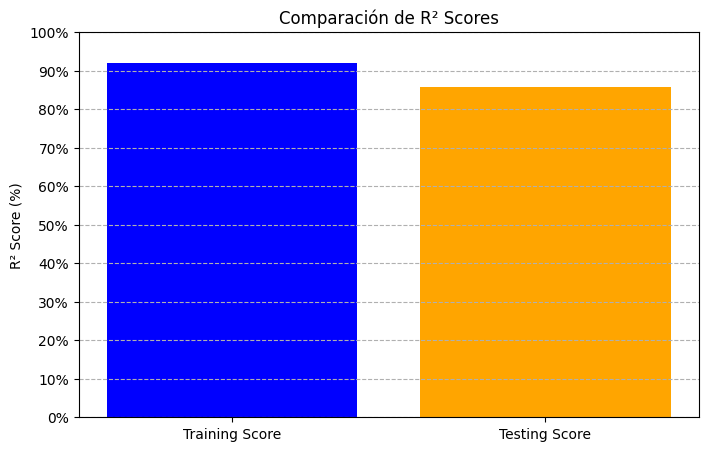

In [65]:
# Se grafican los resultados obtenidos:
# Valores de R²
scores = [train_score_best_gbr, test_score_best_gbr]
labels = ['Training Score', 'Testing Score']

# Convertir a porcentaje
scores_percentage = [score * 100 for score in scores]

# Crear gráfico de barras
plt.figure(figsize=(8, 5))
plt.bar(labels, scores_percentage, color=['blue', 'orange'])
plt.ylim(0, 100)  # Rango de porcentaje
plt.ylabel('R² Score (%)')
plt.title('Comparación de R² Scores')
plt.grid(axis='y', linestyle='--')

# Formatear etiquetas en el eje y como porcentaje
plt.yticks(ticks=np.arange(0, 101, 10), labels=[f'{int(tick)}%' for tick in np.arange(0, 101, 10)])

plt.show()

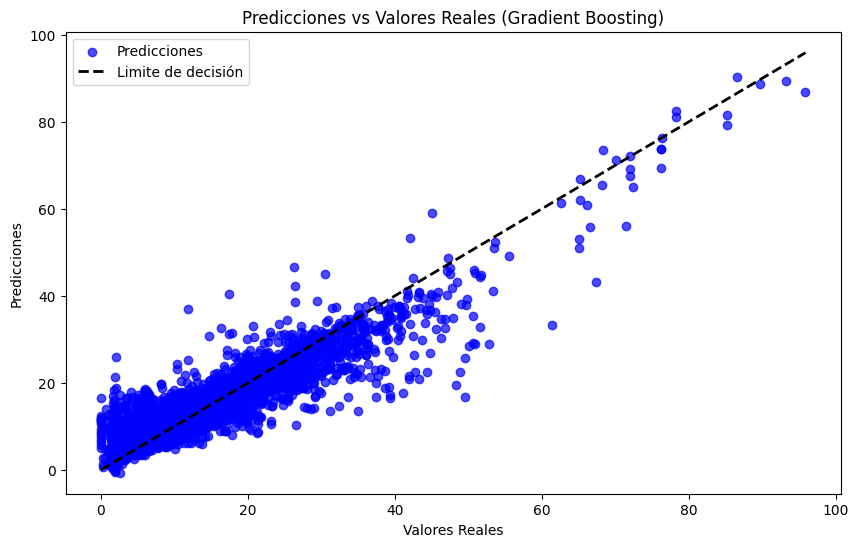

In [66]:
# Crear la gráfica
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_best_grb, alpha=0.7, color='b', label='Predicciones')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2, label='Limite de decisión')

# Etiquetas y título
plt.xlabel('Valores Reales')
plt.ylabel('Predicciones')
plt.title('Predicciones vs Valores Reales (Gradient Boosting)')
plt.legend()
plt.show()

## Benchmarking

In [67]:
# Benchmarking

import pandas as pd

# Crear el DataFrame con las métricas de los modelos
benchmark = pd.DataFrame({
    "MSE": [mse_knn_final, mse_best_rf, mse_best_grb],
    "RMSE": [rmse_knn_final, rmse_best_rf, rmse_best_grb],
    "R² entrenamiento": [train_score_knn_final, train_score_best_rf, train_score_best_gbr],
    "R² prueba": [test_score_knn_final, test_score_best_rf, test_score_best_gbr],
    "MAE": [mae_knn_final, mae_best_rf, mae_best_grb],
    "Tiempo entrenamiento": [train_time_knn, train_time_rf, train_time_gbr],
    "Tiempo predicción": [predict_time_knn, predict_time_rf, predict_time_gbr],
    "Uso de memoria actual": [memoria_knn / 1e6, memoria_rf / 1e6, memoria_gbr / 1e6],  # Conversión a MB
    "Pico de uso de memoria": [peak_knn / 1e6, peak_rf / 1e6, peak_gbr / 1e6],  # Conversión a MB
}, index=["KNN", "Random Forest", "Gradient Boosting"])

# Mostrar el DataFrame
benchmark

,MSE,RMSE,R² entrenamiento,R² prueba,MAE,Tiempo entrenamiento,Tiempo predicción,Uso de memoria actual,Pico de uso de memoria
KNN,8.371040,2.893275,0.916473,0.819680,1.364057,0.135610,0.690314,1.239676,2.253635
Random Forest,7.557568,2.749103,0.907605,0.837203,1.574224,30.035691,0.269239,0.253809,5.307166
Gradient Boosting,6.561413,2.561525,0.918990,0.858661,1.520609,9.905924,0.084110,0.243442,5.307242


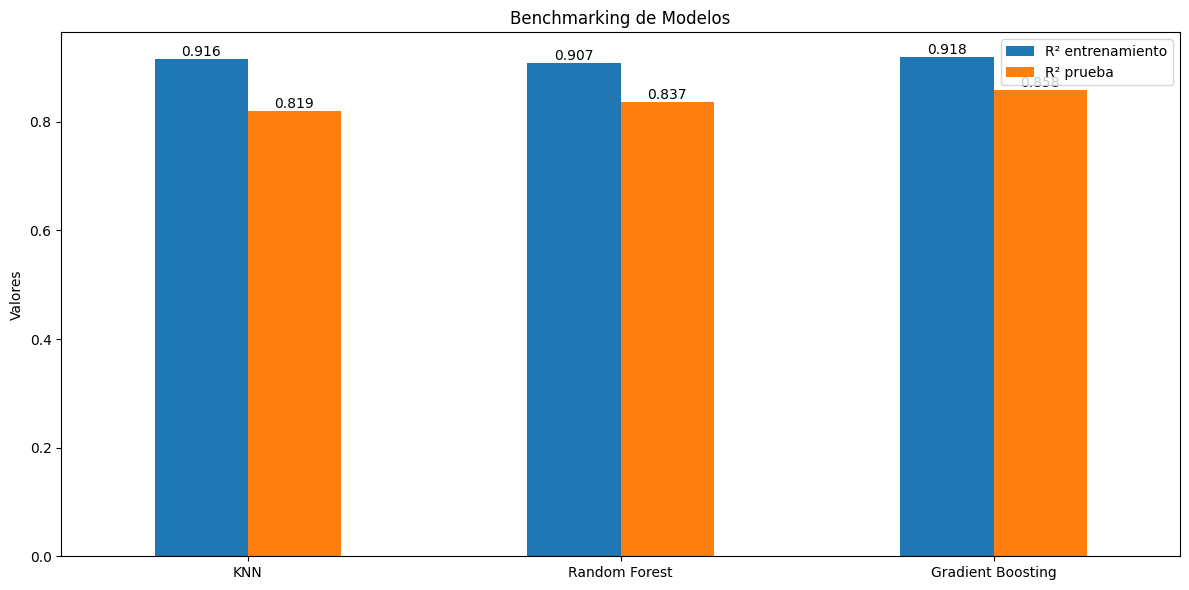

In [68]:
import matplotlib.pyplot as plt

def truncate(value, decimals=3):
    factor = 10 ** decimals
    return int(value * factor) / factor

benchmark_train_test = benchmark[['R² entrenamiento', 'R² prueba']]
# Gráfico de barras para comparar todos los modelos
ax = benchmark_train_test.plot(kind="bar", figsize=(12, 6), title="Benchmarking de Modelos")
plt.ylabel("Valores")
plt.xticks(rotation=0)
plt.legend(loc="best")

# Agregar los valores encima de las barras
for p in ax.patches:
    value = truncate(p.get_height(), 3)  # Truncar a 2 decimales
    ax.annotate(
        f'{value}',  # Mostrar el valor truncado
        (p.get_x() + p.get_width() / 2, p.get_height()),
        ha='center', va='bottom', fontsize=10
    )

plt.tight_layout()
plt.show()

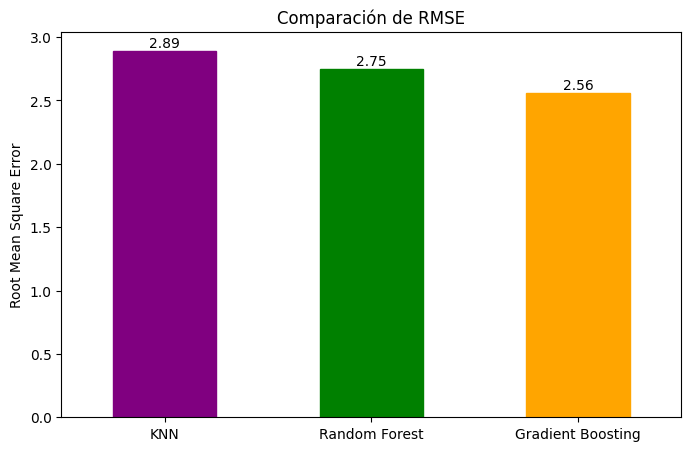

In [69]:
benchmark_RMSE = benchmark[['RMSE']]

ax2 = benchmark_RMSE.plot(kind="bar", color=["blue", "green", "red"], figsize=(8, 5), title="Comparación de RMSE")
# Lista de colores personalizados (uno para cada barra)
colors = [ "purple", "green", "orange"]  # Expande según el número de barras

# Asignar colores a las barras, esto lo hago ya que de forma predeterminada, como todos son RMSE; todos salen en azul
for i, bar in enumerate(ax2.patches):  # Recorrer las barras
    bar.set_color(colors[i % len(colors)])  # Asignar color de forma cíclica


plt.ylabel("Root Mean Square Error")
plt.xticks(rotation=0)
ax2.legend().remove() # Como le cambié el color a las barras, la elimino, ya que no coincide con los colores
# Agregar los valores encima de las barras
for p in ax2.patches:
    
    ax2.annotate(
        f'{p.get_height():.2f}',  # Valor con 2 decimales
        (p.get_x() + p.get_width() / 2, p.get_height()),
        ha='center', va='bottom', fontsize=10
    )

plt.show()

In [70]:
# Datos
models = ['KNN', 'Random Forest',  'Gradient Boosting']
train_times = [train_time_knn, train_time_rf, train_time_gbr]
predict_times = [predict_time_knn, predict_time_rf, predict_time_gbr]

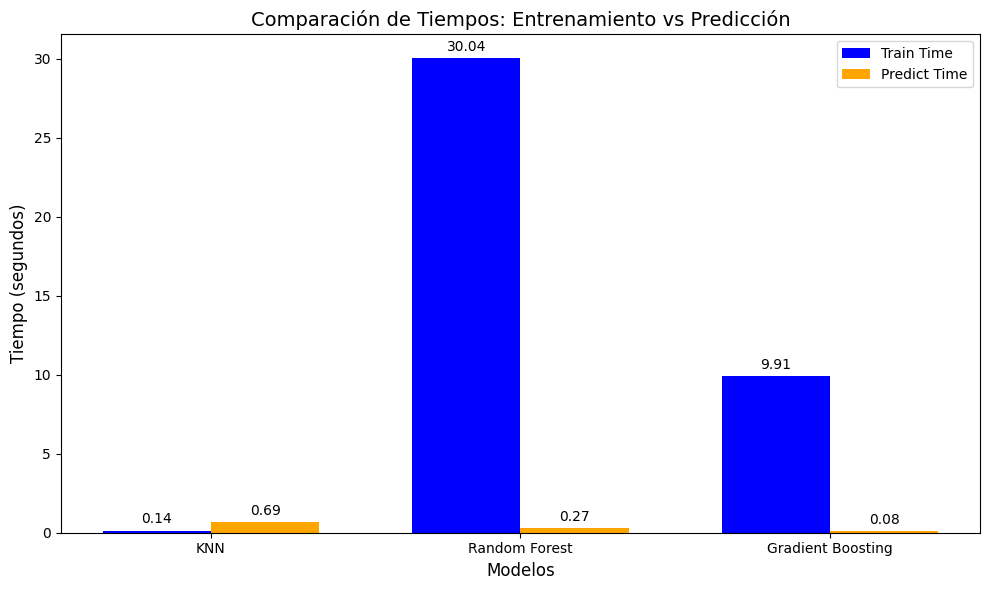

In [71]:
# Crear el gráfico de barras
fig, ax = plt.subplots(figsize=(10, 6))
width = 0.35
x = np.arange(len(models))

bars_train = ax.bar(x - width/2, train_times, width, label='Train Time', color='blue')
bars_predict = ax.bar(x + width/2, predict_times, width, label='Predict Time', color='orange')

# Etiquetas y leyenda
ax.set_xlabel('Modelos', fontsize=12)
ax.set_ylabel('Tiempo (segundos)', fontsize=12)
ax.set_title('Comparación de Tiempos: Entrenamiento vs Predicción', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()

# Agregar valores encima de las barras
for bar in bars_train + bars_predict:
    height = bar.get_height()
    ax.annotate(f'{height:.2f}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),
                textcoords="offset points",
                ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

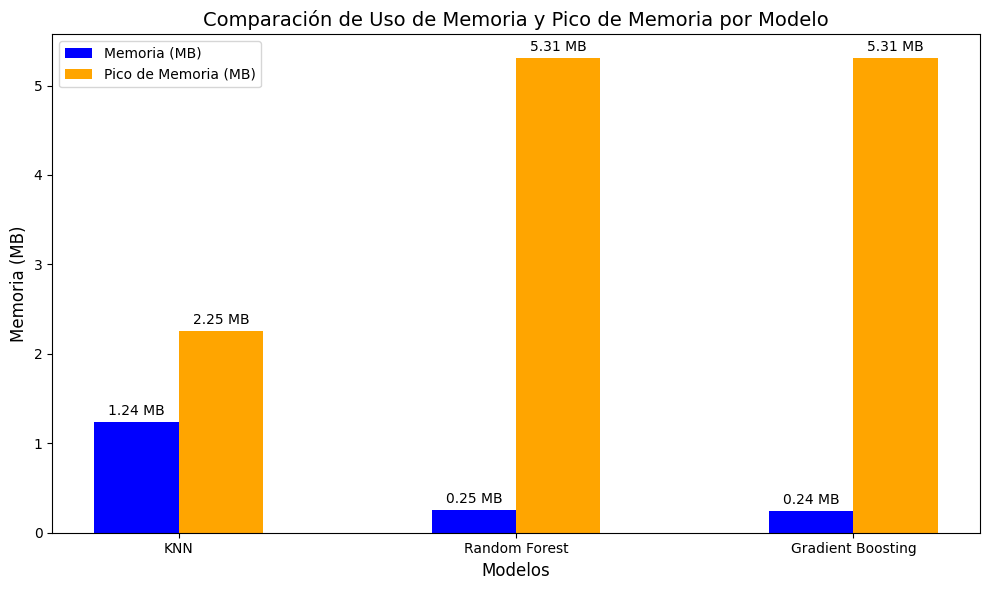

In [72]:
import matplotlib.pyplot as plt
import numpy as np

# Datos en bytes convertidos a MB
models = ['KNN', 'Random Forest', 'Gradient Boosting']
memoria = [memoria_knn / 1e6, memoria_rf / 1e6, memoria_gbr / 1e6]  # Conversión a MB
peak = [peak_knn / 1e6, peak_rf / 1e6, peak_gbr / 1e6]  # Conversión a MB

# Configuración del gráfico
x = np.arange(len(models))  # Posiciones en el eje X
width = 0.25  # Ancho de las barras

fig, ax = plt.subplots(figsize=(10, 6))
bars_memoria = ax.bar(x - width/2, memoria, width, label='Memoria (MB)', color='blue')
bars_peak = ax.bar(x + width/2, peak, width, label='Pico de Memoria (MB)', color='orange')

# Etiquetas y títulos
ax.set_xlabel('Modelos', fontsize=12)
ax.set_ylabel('Memoria (MB)', fontsize=12)
ax.set_title('Comparación de Uso de Memoria y Pico de Memoria por Modelo', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()

# Agregar valores encima de las barras
for bar in bars_memoria + bars_peak:
    height = bar.get_height()
    ax.annotate(f'{height:.2f} MB',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),
                textcoords="offset points",
                ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

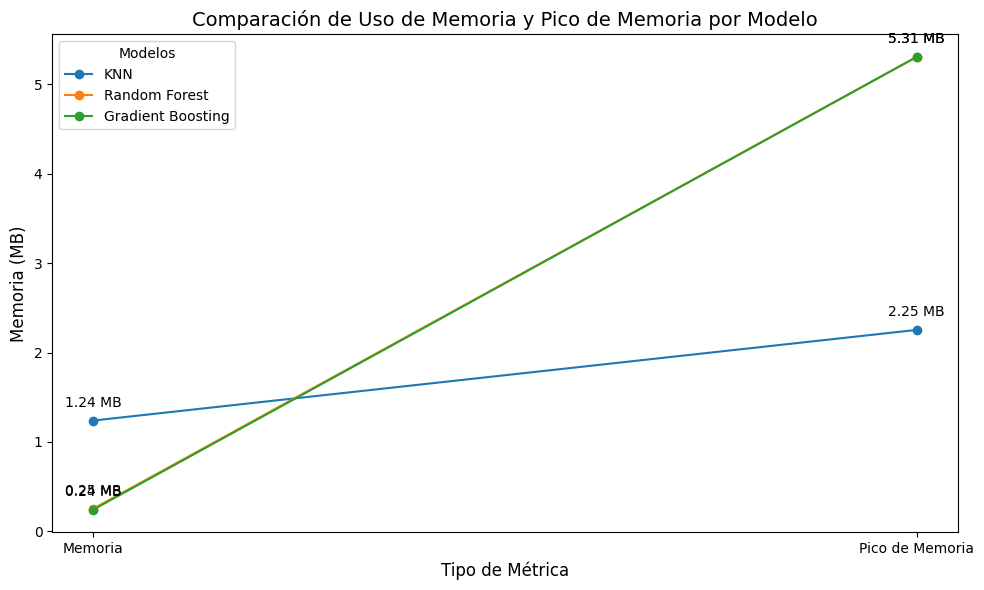

In [73]:
import matplotlib.pyplot as plt
import numpy as np

# Datos en bytes convertidos a MB
models = ['KNN', 'Random Forest', 'Gradient Boosting']
memoria = [memoria_knn / 1e6, memoria_rf / 1e6, memoria_gbr / 1e6]  # Conversión a MB
peak = [peak_knn / 1e6, peak_rf / 1e6, peak_gbr / 1e6]  # Conversión a MB

x_labels = ['Memoria', 'Pico de Memoria']
data = np.array([memoria, peak]).T  # Transponer para representar modelos en filas

# Crear el gráfico
fig, ax = plt.subplots(figsize=(10, 6))

for i, model in enumerate(models):
    ax.plot(x_labels, data[i], marker='o', label=model)  # Una línea por modelo

# Etiquetas y leyendas
ax.set_xlabel('Tipo de Métrica', fontsize=12)
ax.set_ylabel('Memoria (MB)', fontsize=12)
ax.set_title('Comparación de Uso de Memoria y Pico de Memoria por Modelo', fontsize=14)
ax.legend(title="Modelos")

# Agregar valores encima de los puntos, esto con el objetivo de poder ver correctamente las diferencias
for i, model in enumerate(models):
    for j, value in enumerate(data[i]):
        ax.annotate(f'{value:.2f} MB',
                    xy=(x_labels[j], value),
                    textcoords="offset points",
                    xytext=(0, 10),
                    ha='center', fontsize=10)

plt.tight_layout()
plt.show()

## Modelo con mejor rendimiento

Comparando los resultados obtenidos de las métricas de $R^2$ para entrenamiento y prueba de los tres modelos, se nota que las métricas de $R^2$ presentan valores similares para el entrenamiento pero Gradient Booting presenta el mejor valor para la prueba.

Por otro lado Gradient Boosting presenta el menor error (RMSE).

Con respecto a los tiempos de entrenamiento y predicción, KNN es más veloz en el entrenamiento pero más lento en la predicción, esto con respecto a Gradient Boosting. Sin embargo el entrenamiento se hace una vez mientras que la predicción se debe realizar varias veces. Por lo que Gradient Boosting igual presenta la ventaja.

Por último, en cuanto al uso de memoria, KNN presenta un pico menor con respecto a Gradient Boosting lo cual es ventajoso. Sin embargo dado el contexto del problema el uso de memoria no es un limitante.

De esta forma el modelo con mejor rendimiento fue el generado con Gradient Boosting.

## Limitaciones de cada modelo

KNN es un algoritmo más simple dada su pequeña cantidad de hiperparámetros, lo cual por un lado simplifica el entrenamiento y optimización, requiriendo menor tiempo, sin embargo se limita las posibilidades de ajuste para encontrar el punto óptimo.

Por otro lado, para Random Forest y Gradient Boosting ocurre lo contrario, se tiene gran cantidad de hiperparámetros lo cual complica el entrenamiento y optimización, requiriendo más tiempo, sin embargo se tienen más posibilidades de ajuste, lo cual ocurrió con el caso de Gradient Boosting que obtuvo la mejor métrica de $R^2$ para la prueba.

## Mejoras

Es necesario recordar que los datos se generaron a partir de análisis de los circuitos de distribución y los resultados de los análisis de capacidad de alojamiento. Esto quiere decir que las columnas se generaron manualmente, tomando como base lo realizado en el artículo [1], de la mano de razonamiento especializado en el tema. Sin embargo, es posible generar diferentes columnas a partir de nuevos análisis de los circuitos, las cuales podrían utilizarse como características para que los modelos realicen predicciones más acertadas. 

Con respecto a los modelos, hubieron parámetros que no se variaron del valor por defecto, por lo que existen muchas posibilidades de ajuste que podrían llevar a mejores métricas en la prueba.

## Referencias

[1] Qammar, N., Arshad, A., Miller, R.J., Mahmoud, K., Lehtonen, M.: Machine learning based hosting capacity determination methodology for low voltage distribution networks. IET Gener. Transm. Distrib. 18, 911–920 (2024). https://doi.org/10.1049/gtd2.12933